In [13]:
# Analysis on cooling effects from water bodies in Copenhagen 

# changes in Land Surface Temperature (LST) is used to detect the cooling effects

#lst_case.tif: The study area extent is created through a Union and a 
#Dissolve of the lakes_and_sea dataset and the official extents of 
#the two municipalities; the City of Copenhagen and Frederiksberg. 
#The calculated LST result is converted to EPSG:25832 with Project Raster 
#and cut to the case study extent with Extract by Mask and used as template 
#for further raster processing (Environment settings for extent, cell size, 
#mask, and snap raster). 

#lakes.shp and seas.shp: The lakes (or seas respectively) are selected in 
#the lakes_and_sea dataset (Select By Attributes) and extracted to their 
#own layer (Copy Features).  

#lakes_case.tif and seas_case.tif: The lakes (or seas respectively) are 
#converted into a raster (Raster to Polygon) with the same parameters as 
#the LST for the case study area.  

#euc_lake_distV2.tif and euc_seas_distV2.tif: Euclidean Distance is used 
#to calculate the distance to the nearest lake (or sea respectively) for 
#each raster cell following the parameters as the LST for the case study area.  

#lakes_source_near.tif and seas_source_near.tif: Euclidean Allocation is 
#used to provide the id in each raster cell of the nearest lake (or nearest 
#sea polygon respectively) following the parameters as the LST for the 
#case study area.


In [5]:
#pip install statsmodels
#pip install pandas matplotlib
#pip install numpy
#pip install scipy
#pip install geopandas
#pip...

In [66]:
# SETUP
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm  # Import statsmodels for regression
from scipy import stats  # For regression analysis
from scipy.stats import mannwhitneyu
from sklearn.metrics import r2_score


In [68]:
# SETUP
# import rasters
lst = rasterio.open('analysis_input_data/lst_case.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
lakes_source_near = rasterio.open('analysis_input_data/lakes_source_near.tif').read(1).astype('float64') # id of nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea
seas_source_near = rasterio.open('analysis_input_data/seas_source_near.tif').read(1).astype('float64') # id of nearest sea polygon


In [70]:
# SETUP
# Read the shapefile
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
#lakes = gpd.read_file("lakes.shp") # all lake polygons with attribute data
print(lakes.head()) # Show the first few rows of the dataframe

# Read the shapefile
seas = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
print(seas.head()) # Show the first few rows of the dataframe

   fid_    id objekt_typ        kommune    area_ha  perimeter       details  \
0     0  1138         Sø  Frederiksberg   0.096052         73   obs cooling   
1     0   240         Sø      København  14.834820       2288  close to sea   
2     0  1140         Sø      København   3.693557        918   obs cooling   
3     0   517         Sø      København   6.313699        625   obs cooling   
4     0   516         Sø      København   0.804220        389   obs cooling   

   obs_dist    obs_lst    est_dist    est_lst   cool_trend  herbCross  \
0       315  27.794376  171.010603  25.908302     positive        NaN   
1       165  28.605614  242.849081  28.548786  seaPositive        NaN   
2       255  28.224209  223.030366  26.633807     positive        NaN   
3        75  24.103312  230.672440  26.776500     positive        NaN   
4       135  26.649478  201.300379  27.251340     positive        NaN   

   herbCoolCr  woodCoolCr  vegOverlap            vegExplain  \
0         NaN         N

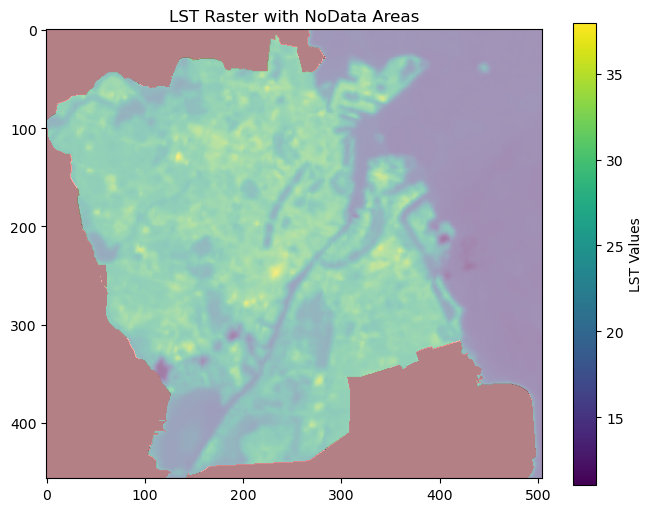

In [72]:
# SETUP
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

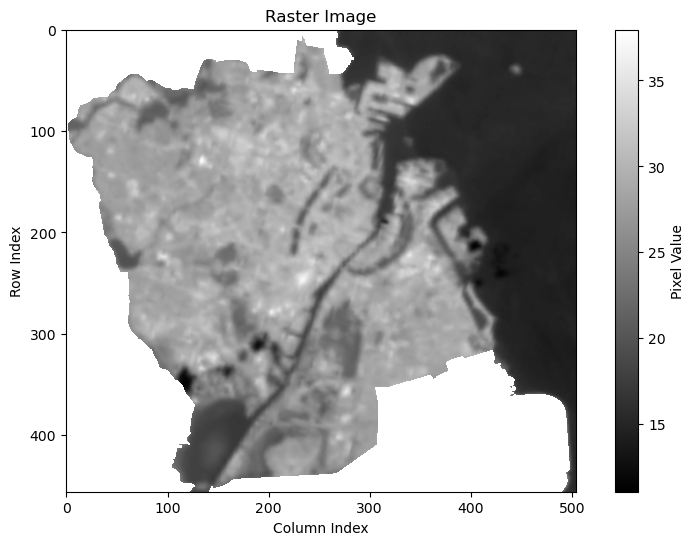

In [74]:
# SETUP
# Plot the LST raster data
plt.figure(figsize=(10, 6))
plt.imshow(lst, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [76]:
# SETUP
# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData

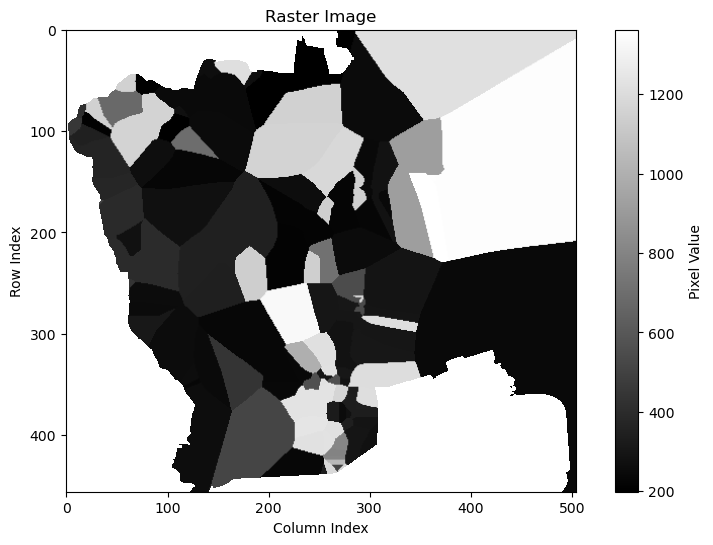

In [78]:
# SETUP
# Plot example raster
plt.figure(figsize=(10, 6))
plt.imshow(lakes_source_near, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

LST at Sea (0m): 24.764605938257635
Turning Point Distance (last increasing point before decrease): 195 meters
LST at First Bin (30-60m): 25.50907450196471
LST at Turning Point: 28.052322790944654
LST Increase Between First Bin (30-60m) and Turning Point: 2.5432482889799424
P-value for logarithmic fit: 0.0006
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


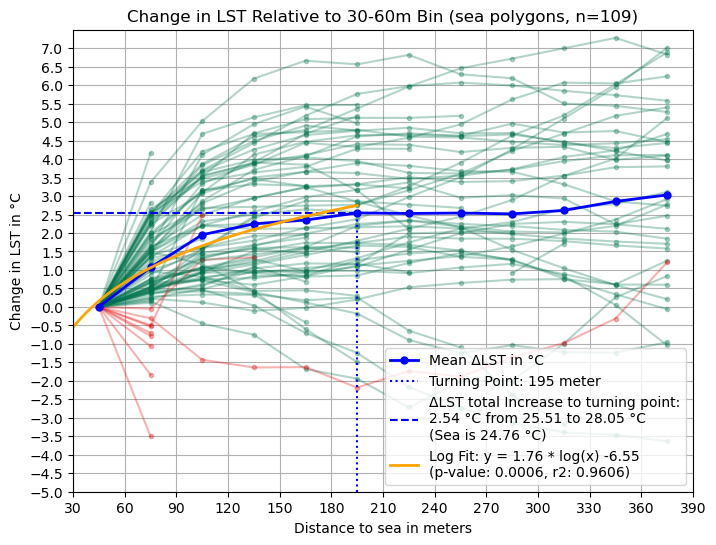

In [80]:
### Analysis 1A: Cooling effect from distance to sea - ALL SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30)  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

ids_of_seas_negative_trend = []
ids_of_seas_positive_trend = []

# Iterate through each unique sea ID
for sea_id in subset_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1)
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute mean LST for each distance bin
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]
    
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red
            if line_color_sea == '#00734C': #00734C=green
                ids_of_seas_positive_trend.append(sea_id)
            elif line_color_sea == '#E60000': #E60000=red
                ids_of_seas_negative_trend.append(sea_id)
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0)  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -5
y_end = 7.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a_sea:.2f} * log(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (sea polygons, n={len(subset_seas)})")
plt.xticks(bins_sea) 
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='lower right')
plt.savefig("Fig1A_sea_all.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Sea (0m): 17.240849435858365
Turning Point Distance (last increasing point before decrease): 195 meters
LST at First Bin (30-60m): 23.15518894373732
LST at Turning Point: 27.073965515977868
LST Increase Between First Bin (30-60m) and Turning Point: 3.9187765722405494
P-value for logarithmic fit: 0.0020
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


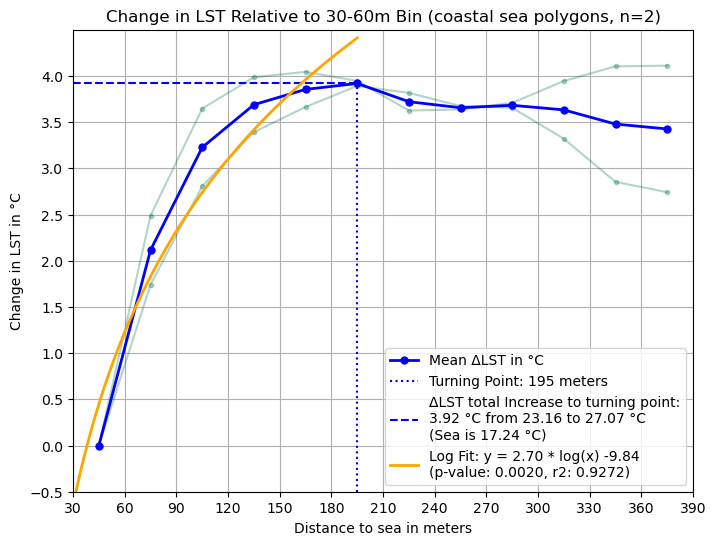

In [35]:
### Analysis 1B: Cooling effect from distance to sea - ONLY LARGER SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30)  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]
# Subset unique_ids_seas_all to only include elements in larger_seas
larger_seas = (1348, 1163)  
subset_larger_seas = subset_seas[np.isin(subset_seas, larger_seas)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

# Iterate through each unique sea ID
for sea_id in subset_larger_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1)
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    #print("we show ", lst[lst_at_0_mask_sea])
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute mean LST for each distance bin
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]
    
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red

        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0)  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -0.5
y_end = 4.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, label=f"Log Fit: y = {a_sea:.2f} * log(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (coastal sea polygons, n={len(subset_larger_seas)})")
plt.xticks(bins_sea)

yticks = np.arange(-0.5, 4.5, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)

plt.grid(True)
plt.legend()
plt.savefig("Fig1B_sea_coastal.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Sea (0m): 24.905236900919306
Turning Point Distance (last increasing point before decrease): 195 meters
LST at First Bin (30-60m): 25.55348743702561
LST at Turning Point: 28.042793440387488
LST Increase Between First Bin (30-60m) and Turning Point: 2.4893060033618792
P-value for logarithmic fit: 0.0006
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


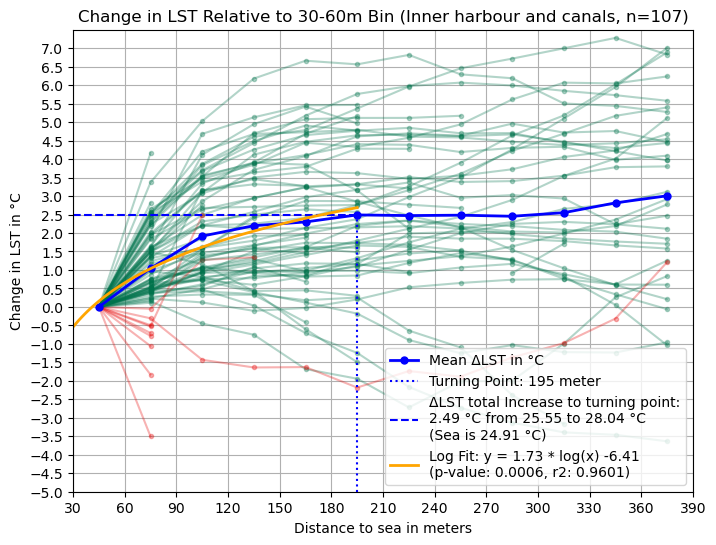

In [37]:
### Analysis 1C: Cooling effect from distance to sea - ONLY INNER SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30)  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]
# Subset unique_ids_seas_all to only include elements in larger_seas
larger_seas = (1348, 1163)
subset_not_larger_seas = subset_seas[~np.isin(subset_seas, larger_seas)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

# Iterate through each unique sea ID
for sea_id in subset_not_larger_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1)
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute mean LST for each distance bin
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]
    
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0)  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -5
y_end = 7.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a_sea:.2f} * log(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Inner harbour and canals, n={len(subset_not_larger_seas)})")
plt.xticks(bins_sea)  
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='lower right')
plt.savefig("Fig1C_sea_inner.png", dpi=300, bbox_inches="tight")
plt.show()


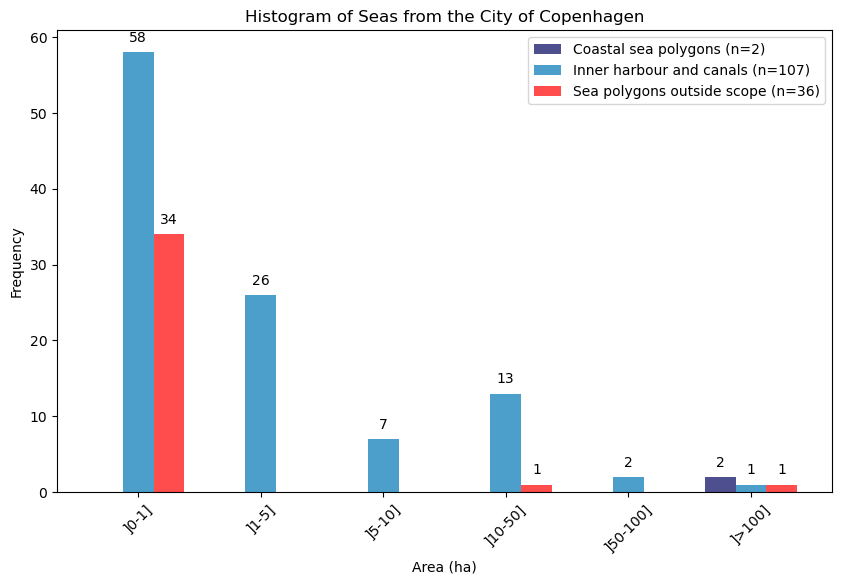

In [39]:
### Analysis 1D:  Histogram of seas

#about the sea statistics:
#110 included in total 
#1 excluded sea 
#2 outer seas
#107 seas in inner harbour and canals 

# Drop the 'geometry' column
seas_stat = seas.drop(columns=['geometry'])

# Create new areaID column and set to 1 for area values between 0 and 1
seas_stat['areaID'] = None  # Initialize areaID with None
seas_stat['areaXlabel'] = None  # Initialize areaXlabel with None

# Set areaID based on area_ha values
seas_stat.loc[(seas_stat['area_ha'] >= 0) & (seas_stat['area_ha'] <= 1), 'areaID'] = 1
seas_stat.loc[(seas_stat['areaID'] == 1), 'areaXlabel'] = ']0-1]'
seas_stat.loc[(seas_stat['area_ha'] > 1) & (seas_stat['area_ha'] <= 5), 'areaID'] = 2
seas_stat.loc[(seas_stat['areaID'] == 2), 'areaXlabel'] = ']1-5]'
seas_stat.loc[(seas_stat['area_ha'] > 5) & (seas_stat['area_ha'] <= 10), 'areaID'] = 3
seas_stat.loc[(seas_stat['areaID'] == 3), 'areaXlabel'] = ']5-10]'
seas_stat.loc[(seas_stat['area_ha'] > 10) & (seas_stat['area_ha'] <= 50), 'areaID'] = 4
seas_stat.loc[(seas_stat['areaID'] == 4), 'areaXlabel'] = ']10-50]'
seas_stat.loc[(seas_stat['area_ha'] > 50) & (seas_stat['area_ha'] <= 100), 'areaID'] = 5
seas_stat.loc[(seas_stat['areaID'] == 5), 'areaXlabel'] = ']50-100]'
seas_stat.loc[(seas_stat['area_ha'] > 100), 'areaID'] = 6
seas_stat.loc[(seas_stat['areaID'] == 6), 'areaXlabel'] = ']>100]'

# Convert areaID to integer for consistency
seas_stat['areaID'] = seas_stat['areaID'].astype('Int64')

# Separate the data based on close-to-sea overlap
# outer seas: 
larger_seas = seas_stat[seas_stat['id'].isin((1348, 1163))]
# inner harbour and canals: 
inner_seas_ids = subset_seas[~np.isin(subset_seas, (1348, 1163))]
inner_seas = seas_stat[seas_stat['id'].isin(inner_seas_ids)]
# Sort seas['id']
sorted_seas_ids = np.sort(seas['id'])
seas_ids_outside_scope = sorted_seas_ids[~np.isin(sorted_seas_ids, subset_seas)]
seas_outside_scope = seas_stat[seas_stat['id'].isin(seas_ids_outside_scope)]

# Ensure DataFrames with areaID as index
larger_seas_counts = larger_seas['areaID'].value_counts().sort_index()
inner_seas_counts = inner_seas['areaID'].value_counts().sort_index()
seas_outside_scope_counts = seas_outside_scope['areaID'].value_counts().sort_index()

# Ensure all areaIDs are present in all three datasets (union of the indices)
all_areaIDs = sorted(set(larger_seas_counts.index).union(set(inner_seas_counts.index)))

# Reindex to include all possible areaIDs (fill missing with 0)
larger_seas_counts = larger_seas_counts.reindex(all_areaIDs, fill_value=0)
inner_seas_counts = inner_seas_counts.reindex(all_areaIDs, fill_value=0)
seas_outside_scope_counts = seas_outside_scope_counts.reindex(all_areaIDs, fill_value=0)

# Convert to NumPy arrays for consistency
larger_seas_counts = larger_seas_counts.values
inner_seas_counts = inner_seas_counts.values
seas_outside_scope_counts = seas_outside_scope_counts.values

# Define bar positions and width
bar_width = 0.25  # Adjust width to fit three sets of bars
x_positions = np.array(all_areaIDs)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x_positions - bar_width, larger_seas_counts, width=bar_width, color='#03045E', 
                alpha=0.7, label=f'Coastal sea polygons (n={str(np.sum(larger_seas_counts))})')
bars2 = plt.bar(x_positions, inner_seas_counts, width=bar_width, color="#0077B6",  
                alpha=0.7, label=f'Inner harbour and canals (n={str(np.sum(inner_seas_counts))})')
bars3 = plt.bar(x_positions + bar_width, seas_outside_scope_counts, width=bar_width, color='red', 
                alpha=0.7, label=f'Sea polygons outside scope (n={str(np.sum(seas_outside_scope_counts))})')
                
# Add labels on top of bars
for bar in bars1:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

for bar in bars2:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

for bar in bars3:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel("Area (ha)")
plt.ylabel("Frequency")
plt.title("Histogram of Seas from the City of Copenhagen")

# Set x-axis labels to areaXlabel values
area_labels = [seas_stat[seas_stat['areaID'] == areaID]['areaXlabel'].iloc[0] for areaID in all_areaIDs]
plt.xticks(x_positions, labels=area_labels, rotation=45)

plt.legend()

plt.savefig("Fig1D_seas_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



LST at Lakes (0m): 25.393817348811357
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 25.74732333402742
LST at Turning Point: 27.501800229730385
LST Increase Between First Bin (30-60m) and Turning Point: 1.7544768957029662
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


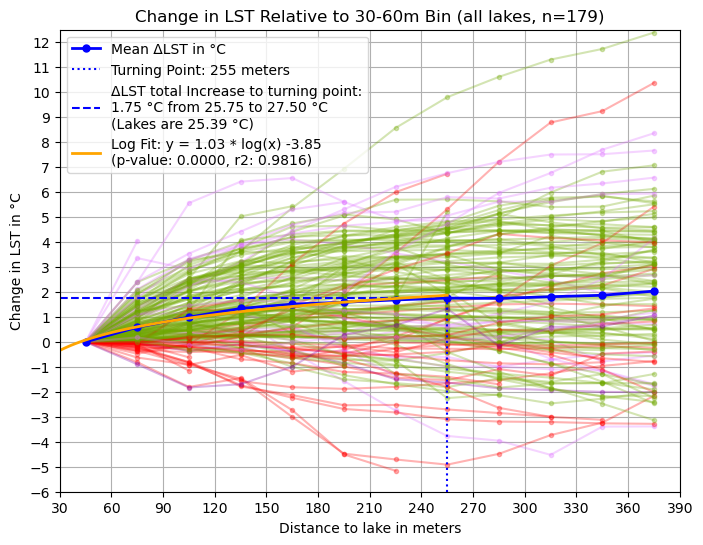

In [41]:
### Analysis 2A: Cooling effect from distance to all lakes 
# with lakes within 195 metres to the seas colored differently
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Get all unique lake IDs, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Storage for lake IDs
ids_of_lakes_close_to_sea = []
ids_of_lakes_not_close_to_sea = []
ids_of_lakes_others = []
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        ids_of_lakes_others.append(lake_id)
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                ids_of_lakes_close_to_sea.append(lake_id)
                if delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                ids_of_lakes_not_close_to_sea.append(lake_id)
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)

        else:
            ids_of_lakes_others.append(lake_id)
            continue  # Skip plotting if NaN values exist
    except IndexError:
        ids_of_lakes_others.append(lake_id)
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 12.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")
 
        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (all lakes, n={179})") #len(unique_ids) is 182 but these include 3=justOutOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig2A_lakes_all.png", dpi=300, bbox_inches="tight")
plt.show()


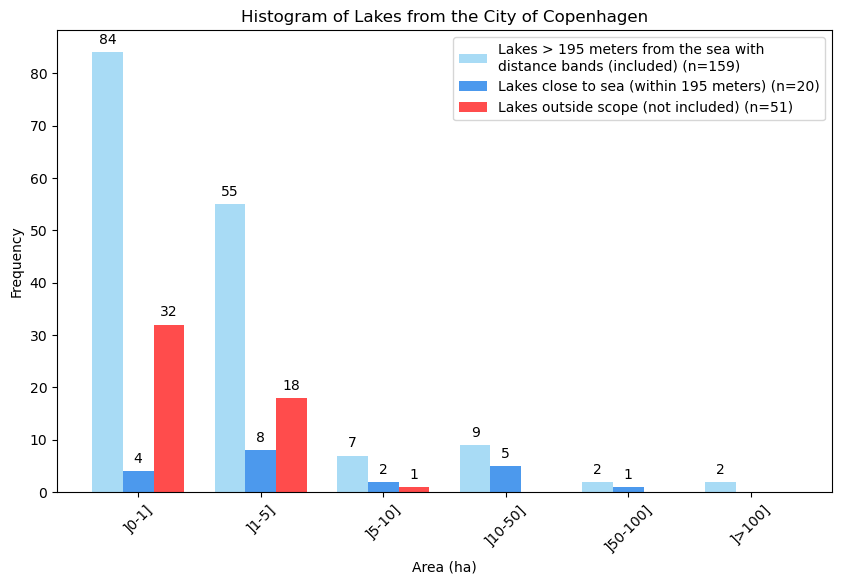

In [43]:
### Analysis 2B:  Histogram of lakes
### Visualise lakes-close-to-seas separately 

#about the lake statistics:
#230 lakes in total 
#17 lakes are close to seas
#48 lakes are outside scope (thus not part of lakes_source_near and thus not part of unique_ids)  
#3 lakes are almost outside scope (on the border to the study area so excluded in analysis)
#162 lakes are further from seas with distance bands 

# Drop the 'geometry' column
lakes_stat = lakes.drop(columns=['geometry'])
#lakes_stat = lakes.copy()

# Create new areaID column and set to 1 for area values between 0 and 1
lakes_stat['areaID'] = None  # Initialize areaID with None
lakes_stat['areaXlabel'] = None  # Initialize areaXlabel with None

# Set areaID based on area_ha values
lakes_stat.loc[(lakes_stat['area_ha'] >= 0) & (lakes_stat['area_ha'] <= 1), 'areaID'] = 1
lakes_stat.loc[(lakes_stat['areaID'] == 1), 'areaXlabel'] = ']0-1]'
lakes_stat.loc[(lakes_stat['area_ha'] > 1) & (lakes_stat['area_ha'] <= 5), 'areaID'] = 2
lakes_stat.loc[(lakes_stat['areaID'] == 2), 'areaXlabel'] = ']1-5]'
lakes_stat.loc[(lakes_stat['area_ha'] > 5) & (lakes_stat['area_ha'] <= 10), 'areaID'] = 3
lakes_stat.loc[(lakes_stat['areaID'] == 3), 'areaXlabel'] = ']5-10]'
lakes_stat.loc[(lakes_stat['area_ha'] > 10) & (lakes_stat['area_ha'] <= 50), 'areaID'] = 4
lakes_stat.loc[(lakes_stat['areaID'] == 4), 'areaXlabel'] = ']10-50]'
lakes_stat.loc[(lakes_stat['area_ha'] > 50) & (lakes_stat['area_ha'] <= 100), 'areaID'] = 5
lakes_stat.loc[(lakes_stat['areaID'] == 5), 'areaXlabel'] = ']50-100]'
lakes_stat.loc[(lakes_stat['area_ha'] > 100), 'areaID'] = 6
lakes_stat.loc[(lakes_stat['areaID'] == 6), 'areaXlabel'] = ']>100]'

# Convert areaID to integer for consistency
lakes_stat['areaID'] = lakes_stat['areaID'].astype('Int64')

# Separate the data based on close-to-sea overlap
# close to sea <= 195 meters distance (in ids_of_lakes_close_to_sea): 
lakes_close_to_sea = lakes_stat[lakes_stat['id'].isin(ids_of_lakes_close_to_sea)]
# further from sea (in unique_ids but not in ids_of_lakes_close_to_sea and not in ids_of_lakes_others): 
lakes_with_distancebands = lakes_stat[lakes_stat['id'].isin(unique_ids) & ~lakes_stat['id'].isin(ids_of_lakes_close_to_sea) & ~lakes_stat['id'].isin(ids_of_lakes_others)]
# other lakes (in ids_of_lakes_others but not in ids_of_lakes_close_to_sea and not in unique_ids)
lakes_other = lakes_stat[~lakes_stat['id'].isin(unique_ids) | lakes_stat['id'].isin(ids_of_lakes_others)]

# Ensure lakes_close_to_sea and lakes_other are DataFrames with areaID as index
lakes_with_distancebands_counts = lakes_with_distancebands['areaID'].value_counts().sort_index()
lakes_other_counts = lakes_other['areaID'].value_counts().sort_index()
lakes_close_to_sea_counts = lakes_close_to_sea['areaID'].value_counts().sort_index()

# Ensure all areaIDs are present in all three datasets (union of the indices)
all_areaIDs = sorted(set(lakes_other_counts.index).union(set(lakes_close_to_sea_counts.index), set(lakes_with_distancebands_counts.index)))

# Reindex to include all possible areaIDs (fill missing with 0)
lakes_other_counts = lakes_other_counts.reindex(all_areaIDs, fill_value=0)
lakes_close_to_sea_counts = lakes_close_to_sea_counts.reindex(all_areaIDs, fill_value=0)
lakes_with_distancebands_counts = lakes_with_distancebands_counts.reindex(all_areaIDs, fill_value=0)

# Convert to NumPy arrays for consistency
lakes_other_counts = lakes_other_counts.values
lakes_close_to_sea_counts = lakes_close_to_sea_counts.values
lakes_with_distancebands_counts = lakes_with_distancebands_counts.values

# Define bar positions and width
bar_width = 0.25  # Adjust width to fit three sets of bars
x_positions = np.array(all_areaIDs)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x_positions - bar_width, lakes_with_distancebands_counts, width=bar_width, color='#83CCF2', 
                alpha=0.7, label=f'Lakes > 195 meters from the sea with\ndistance bands (included) (n={str(np.sum(lakes_with_distancebands_counts))})')
bars2 = plt.bar(x_positions, lakes_close_to_sea_counts, width=bar_width, color='#006EE6', 
                alpha=0.7, label=f'Lakes close to sea (within 195 meters) (n={str(np.sum(lakes_close_to_sea_counts))})')
bars3 = plt.bar(x_positions + bar_width, lakes_other_counts, width=bar_width, color='red', 
                alpha=0.7, label=f'Lakes outside scope (not included) (n={str(np.sum(lakes_other_counts))})')
                
# Add labels on top of bars
for bar in bars1:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

for bar in bars2:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

for bar in bars3:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel("Area (ha)")
plt.ylabel("Frequency")
plt.title("Histogram of Lakes from the City of Copenhagen")

# Set x-axis labels to areaXlabel values
area_labels = [lakes_stat[lakes_stat['areaID'] == areaID]['areaXlabel'].iloc[0] for areaID in all_areaIDs]
plt.xticks(x_positions, labels=area_labels, rotation=45)

plt.legend()

plt.savefig("Fig2B_lakes_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



In [45]:
### Analysis 2C: Weighted and unweighted average turning points 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(0, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 0 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store values for weighted calculations
turning_points = []
areas = []  # To store lake areas
perimeters = []  # To store lake perimeters
area_perimeter_ratios = []  # To store area/perimeter ratios
lsi_values = []  # To store LSI values

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    # Create a mask: filter by lake ID, exclude seas_case == 1, remove NaNs
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue  # Skip if no valid data points

    # Compute mean LST for `dist = 0`
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    # Create a mask excluding `dist = 0`
    mask = base_mask & (lake_dist > 0)

    if np.sum(mask) == 0:
        continue  # Skip if no valid data points after removing dist=0

    # Extract valid values
    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1

    # Compute mean LST for each distance bin (excluding `dist = 0`)
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Compute change in LST (ΔLST) relative to `dist = 0`
    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    # Calculate the slope between successive bins
    slopes = np.diff(delta_lst) / np.diff(bin_labels)

    # Find the last increasing point before a decrease (turning point)
    turning_point_index = np.argmax(slopes < 0)  
    
    if turning_point_index > 0:
        turning_point_distance = bin_labels[turning_point_index]  
    else:
        turning_point_distance = np.nan  # No clear turning point found

    # Identify indices where the slope is positive (increasing trend)
    if turning_point_index >= 0:
        #turning_point_distance = bin_labels[turning_point_index + 1]  # Turning point is at the corresponding bin label
        turning_points.append(turning_point_distance)
        #print (turning_point_distance, " turning point dist")

        # Get lake properties
        lake_area = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0]
        lake_perimeter = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'perimeter'].values[0]

        # Compute additional weighting factors
        area_perimeter_ratio = (lake_area * 10000) / lake_perimeter  # Convert area_ha to m²
        lsi = lake_perimeter / (2 * np.sqrt(np.pi * (lake_area * 10000)))  # LSI formula

        # Store values for weighted averages
        areas.append(lake_area)
        perimeters.append(lake_perimeter)
        area_perimeter_ratios.append(area_perimeter_ratio)
        lsi_values.append(lsi)

# Remove NaN values before computing mean
turning_points_clean = [tp for tp in turning_points if not np.isnan(tp)]

# Compute and print weighted averages
if turning_points_clean:
    print(f"Unweighted Average Turning Point Distance: {np.mean(turning_points_clean):.2f} meters")

    # Weighted by area
    areas_clean = [areas[i] for i in range(len(areas)) if not np.isnan(turning_points[i])]
    #turning_points_clean = [tp for tp in turning_points if not np.isnan(tp)]

    weighted_by_area = np.average(turning_points_clean, weights=areas_clean) if areas_clean else np.nan
    print(f"Weighted Average Turning Point Distance (Weighted by Area): {weighted_by_area:.2f} meters")

    # Weighted by perimeter
    perimeter_clean = [perimeters[i] for i in range(len(perimeters)) if not np.isnan(turning_points[i])]
    #turning_points_clean = [tp for tp in turning_points if not np.isnan(tp)]

    weighted_by_perimeter = np.average(turning_points_clean, weights=perimeter_clean) if perimeters else np.nan
    print(f"Weighted Average Turning Point Distance (Weighted by Perimeter): {weighted_by_perimeter:.2f} meters")

    # Weighted by area/perimeter ratio
    area_perimeter_clean = [area_perimeter_ratios[i] for i in range(len(area_perimeter_ratios)) if not np.isnan(turning_points[i])]
    #turning_points_clean = [tp for tp in turning_points if not np.isnan(tp)]

    weighted_by_area_perimeter = np.average(turning_points_clean, weights=area_perimeter_clean) if area_perimeter_ratios else np.nan
    print(f"Weighted Average Turning Point Distance (Weighted by Area/Perimeter): {weighted_by_area_perimeter:.2f} meters")

    # Weighted by LSI
    lsi_values_clean = [lsi_values[i] for i in range(len(lsi_values)) if not np.isnan(turning_points[i])]
    #turning_points_clean = [tp for tp in turning_points if not np.isnan(tp)]

    weighted_by_lsi = np.average(turning_points_clean, weights=lsi_values_clean) if lsi_values else np.nan
    print(f"Weighted Average Turning Point Distance (Weighted by LSI): {weighted_by_lsi:.2f} meters")

else:
    print("No valid turning points found.")


Unweighted Average Turning Point Distance: 151.82 meters
Weighted Average Turning Point Distance (Weighted by Area): 214.16 meters
Weighted Average Turning Point Distance (Weighted by Perimeter): 176.53 meters
Weighted Average Turning Point Distance (Weighted by Area/Perimeter): 188.14 meters
Weighted Average Turning Point Distance (Weighted by LSI): 152.36 meters


LST at Lakes (0m): 24.138498140709483
Turning Point Distance (last increasing point before decrease): 135 meters
LST at First Bin (30-60m): 24.346053286861814
LST at Turning Point: 25.431521170228617
LST Increase Between First Bin (30-60m) and Turning Point: 1.0854678833668017
P-value for logarithmic fit: 0.0674


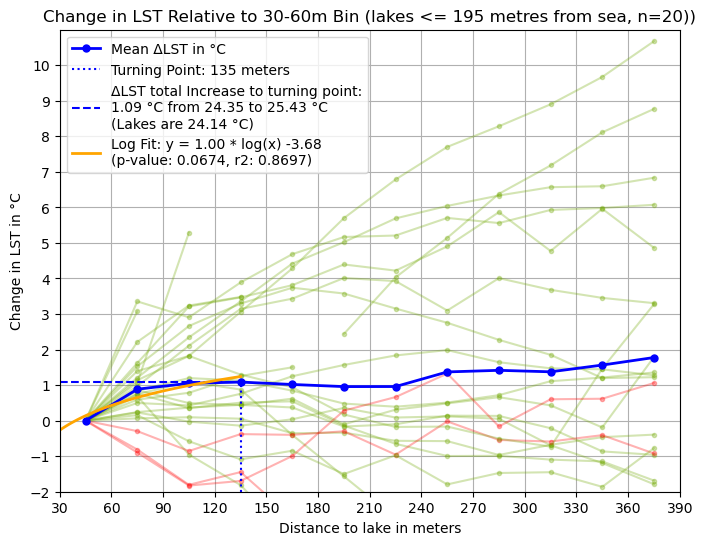

In [47]:
### Analysis 3A: Cooling effect from distance to lakes close to sea  
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist <= 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (lakes <= 195 metres from sea, n=20))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig3A_lakes_closeToSea.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 25.46736569044666
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 25.808622458495954
LST at Turning Point: 27.62742344119567
LST Increase Between First Bin (30-60m) and Turning Point: 1.8188009826997156
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


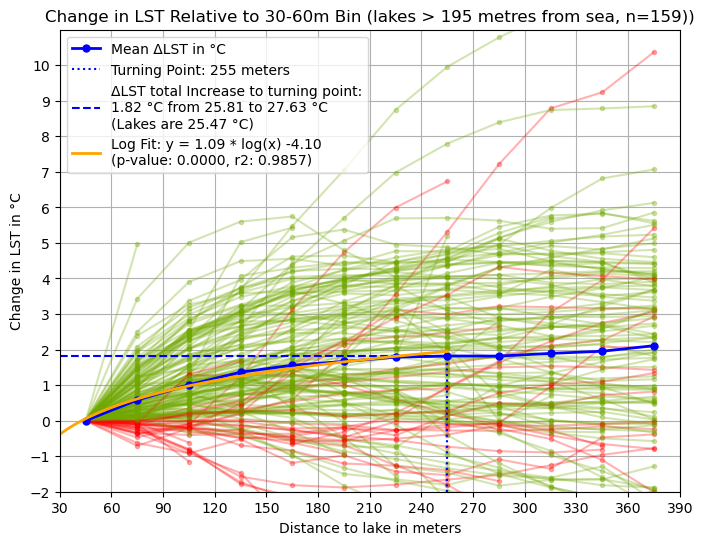

In [49]:
### Analysis 3B: Cooling effect from distance to lakes further from sea  
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (lakes > 195 metres from sea, n=159))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig3B_lakes_farFromSea.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 22.94501269848251
Turning Point Distance (last increasing point before decrease): 165 meters
LST at First Bin (30-60m): 24.455099434257843
LST at Turning Point: 27.265600687100317
LST Increase Between First Bin (30-60m) and Turning Point: 2.8105012528424727
P-value for logarithmic fit: 0.0003
The logarithmic fit is statistically significant.


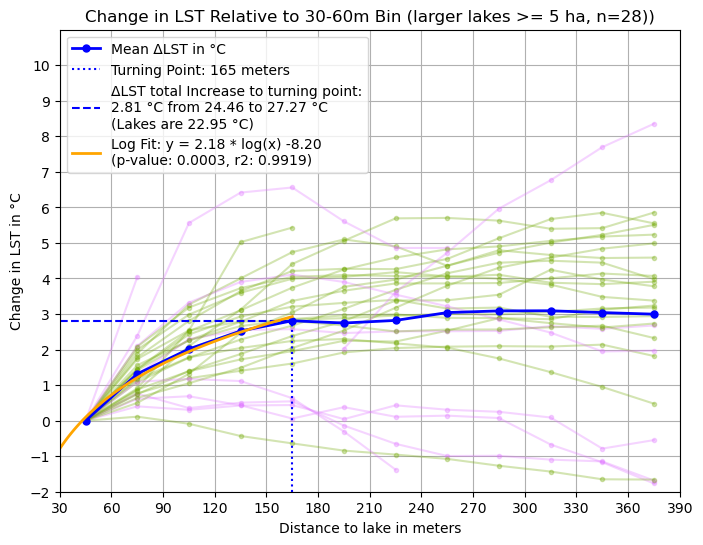

In [51]:
### Analysis 4A: Cooling effect from distance to larger lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size >= 5. ha (threshold value for showing cooling effect) 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 5.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (larger lakes >= 5 ha, n=28))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig4A_lakes_high_area.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 25.839054557962065
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 25.98694101080589
LST at Turning Point: 27.471633057549415
LST Increase Between First Bin (30-60m) and Turning Point: 1.484692046743524
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


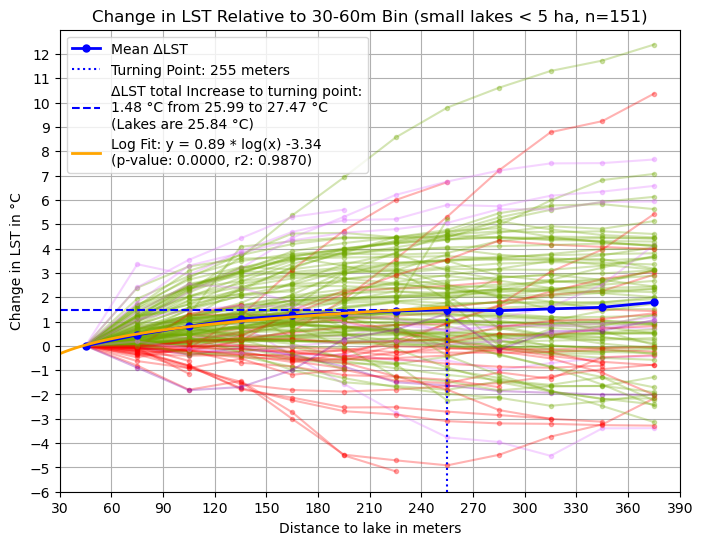

In [53]:
### Analysis 4B: Cooling effect from distance to all lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size < 5. ha (threshold value for showing cooling effect is 5 ha) 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area smaller than 5 ha
lakes_filtered = lakes[lakes['area_ha'] < 5.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get LST at the turning point which equals LST increase 
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 13
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (small lakes < 5 ha, n=151)") #{len(unique_ids)-29} 3 outOfScope has been left out
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig4B_lakes_low_area.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 23.383749870782207
Turning Point Distance (last increasing point before decrease): 375 meters
LST at First Bin (30-60m): 24.636406225345745
LST at Turning Point: 27.641942353151137
LST Increase Between First Bin (30-60m) and Turning Point: 3.005536127805394
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


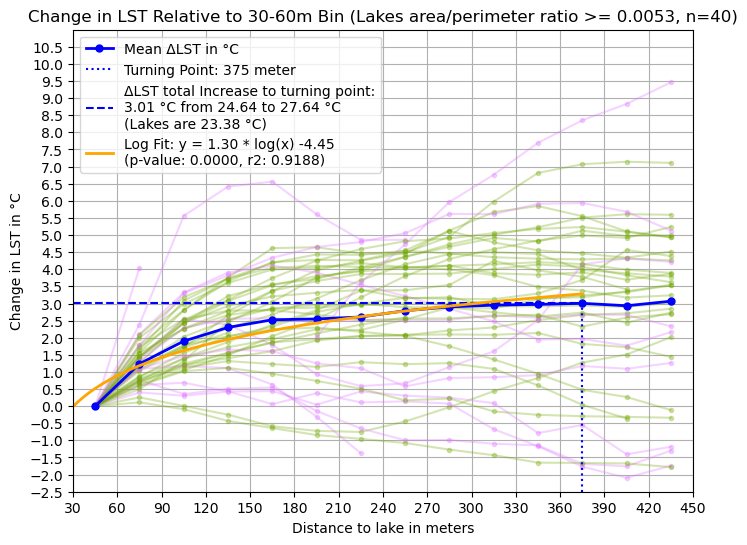

In [55]:
### Analysis 5A: Cooling effect from distance to all lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size/perimeter ratio >= 0.0053 (threshold value for showing cooling effect is 0.0053) 

# Define distance bins (30-60, 60-90, ..., 390-480)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Calculate the area/perimeter ratio
lakes['area_perimeter_ratio'] = lakes['area_ha'] / lakes['perimeter']

# Filter lakes with large area/perimeter ratio
lakes_filtered = lakes[lakes['area_perimeter_ratio'] >= 0.0053]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 480) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]
    
    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2.5
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes area/perimeter ratio >= 0.0053, n=40)") #{len(np.sort(lakes_filtered['id']))} 46 but 6 are out of scope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig5A_lakes_high_perimeter.png", dpi=300, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 25.96003353980549
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 26.067011710626463
LST at Turning Point: 27.47043231049246
LST Increase Between First Bin (30-60m) and Turning Point: 1.4034205998659945
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


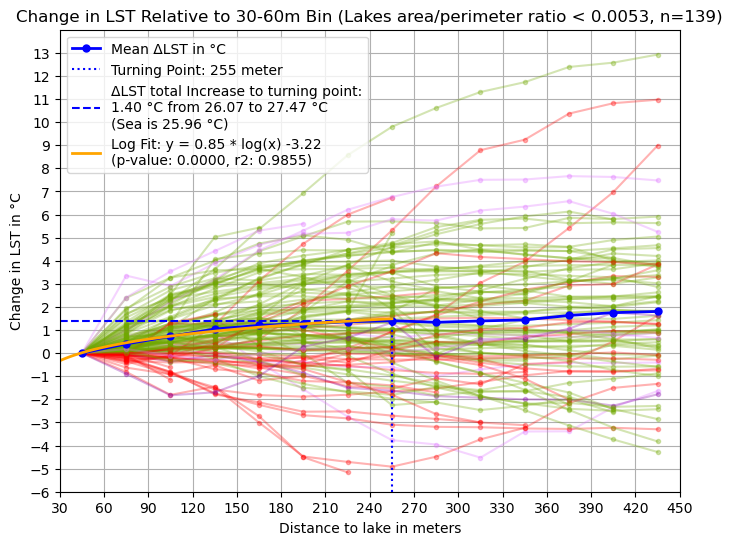

In [57]:
### Analysis 5B: Cooling effect from distance to all lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size/perimeter ratio < 0.0053 (threshold value for showing cooling effect is 0.0053) 

# Define distance bins (30-60, 60-90, ..., 390-480)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Calculate the area/perimeter ratio
lakes['area_perimeter_ratio'] = lakes['area_ha'] / lakes['perimeter']

# Filter lakes with small area/perimeter ratio
lakes_filtered = lakes[lakes['area_perimeter_ratio'] < 0.0053]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 480) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]
    
    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 14
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Sea is {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes area/perimeter ratio < 0.0053, n=139)") #132 with cooling far from sea and with low area/perimeter #7 with cooling close to sea and with low area/perimeter #len(np.sort(lakes_filtered['id'])) includes out of scope too
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig5B_lakes_low_perimeter.png", dpi=300, bbox_inches="tight")
plt.show()


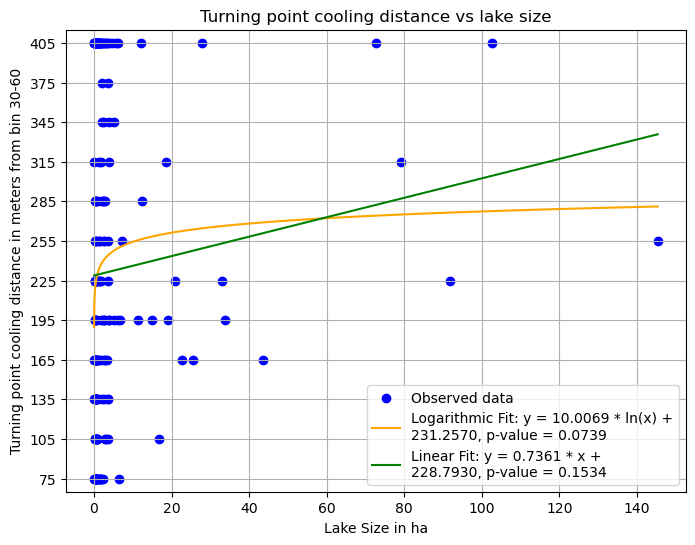

P-value for the logarithmic fit: 0.0739
The logarithmic fit formula is: y = 10.0069 * ln(x) + 231.2570
P-value for the linear fit: 0.1534
The linear fit formula is: y = 0.7361 * x + 228.7930


In [59]:
### Analysis 6A: Turning point distance to bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# List to store turning points and corresponding lake sizes
turning_points = []
lake_sizes = []

# Initialize figure for plotting both fits
plt.figure(figsize=(8, 6))

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = delta_lst[first_bin_index] if not np.isnan(delta_lst[first_bin_index]) else np.nan

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    for i in range(1, len(mean_lst_values)):
        if mean_lst_values[i] < mean_lst_values[i - 1]:  
            break  
        turning_point_index = i  

    if turning_point_index >= 0:
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Plot the turning points vs lake size as a scatter plot
plt.scatter(lake_sizes, turning_points, c='blue', marker='o', label="Observed data")

# Logarithmic Fit
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, turning_points)

# Plot the fitted logarithmic curve
x_vals_log = np.linspace(min(log_lake_sizes), max(log_lake_sizes), 100)
y_vals_log = slope_log * x_vals_log + intercept_log  # Logarithmic fit line
plt.plot(np.exp(x_vals_log), y_vals_log, color='orange', label=f"Logarithmic Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p-value = {p_value_log:.4f}")

# Linear Fit
slope_lin, intercept_lin, r_value_lin, p_value_lin, std_err_lin = stats.linregress(lake_sizes, turning_points)

# Plot the fitted linear trend
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_lin * x_vals_lin + intercept_lin
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_lin:.4f} * x +\n{intercept_lin:.4f}, p-value = {p_value_lin:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling distance in meters from bin 30-60")
plt.title("Turning point cooling distance vs lake size")

# Adjust y-axis
plt.ylim(min(turning_points) - 10, max(turning_points) + 10)  
plt.yticks(np.unique(turning_points))

# Show grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

plt.savefig("Fig6A_turningPointDistance30VSlakeSize.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Print results for both fits
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_lin:.4f}")
print(f"The linear fit formula is: y = {slope_lin:.4f} * x + {intercept_lin:.4f}")


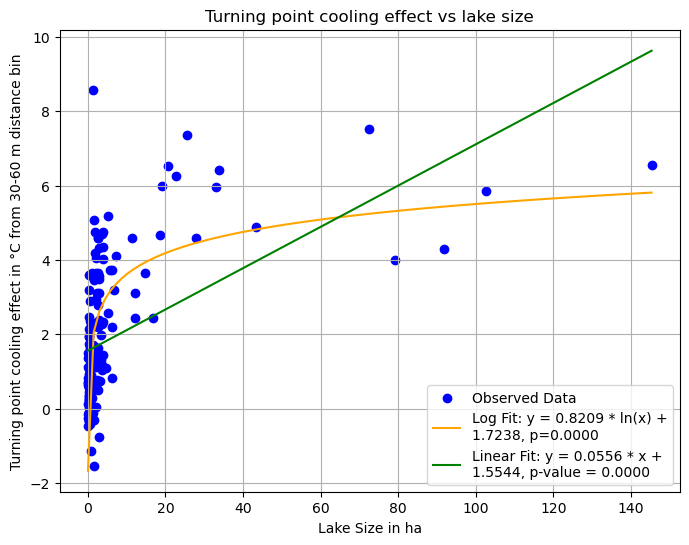

P-value for the logarithmic fit: 0.0000
The logarithmic fit formula is: y = 0.8209 * ln(x) + 1.7238
P-value for the linear fit: 0.0000
The linear fit formula is: y = 0.0556 * x + 1.5544


In [63]:
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = delta_lst[first_bin_index] if not np.isnan(delta_lst[first_bin_index]) else np.nan

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    for i in range(1, len(mean_lst_values)):
        if mean_lst_values[i] < mean_lst_values[i - 1]:  
            break  
        turning_point_index = i  

    if turning_point_index >= 0:
        # Compute mean increase in LST from bin 1 to turning point
        lst_values_to_avg = delta_lst[first_bin_index:turning_point_index + 1]
        lst_values_to_avg = [val for val in lst_values_to_avg if not np.isnan(val)]  # Remove NaNs
        mean_lst_increase = np.mean(lst_values_to_avg) if len(lst_values_to_avg) > 0 else np.nan

        if not np.isnan(mean_lst_increase):
            mean_LST_increases.append(mean_lst_increase)
            lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, mean_LST_increases, c='blue', marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs lake size")

# Display grid and legend
plt.grid(True)
plt.legend()  # This will automatically pull the correct labels from the plot elements

plt.savefig("Fig6B_turningPointlst30VSlakeSize.png", dpi=300, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")
print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


<Figure size 800x600 with 0 Axes>

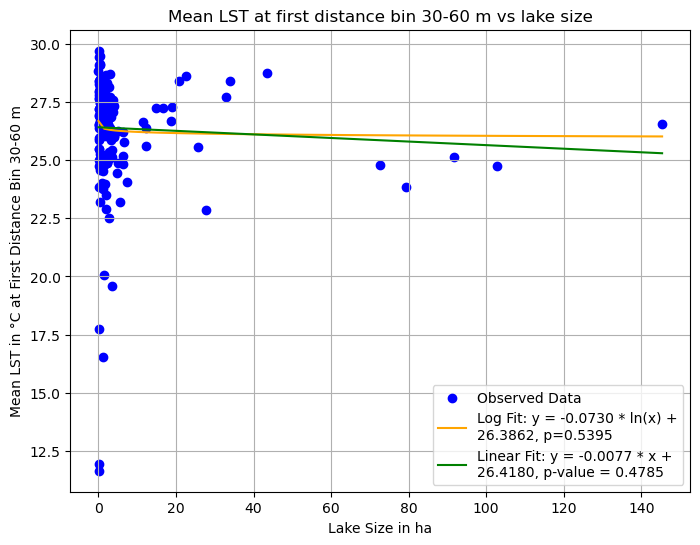

P-value for the logarithmic fit: 0.5395
The logarithmic fit formula is: y = -0.0730 * ln(x) + 26.3862
P-value for the linear fit: 0.4785
The linear fit formula is: y = -0.0077 * x + 26.4180


In [67]:
### Analysis 6C: Mean LST at lake distance to bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
first_bin_LSTs = []  # Mean LST at first bin (30-60m)
lake_sizes = []

plt.figure(figsize=(8, 6))  # Initialize figure

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))

    mask = base_mask & (lake_dist > 0)
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = mean_lst_values[first_bin_index] if not np.isnan(mean_lst_values[first_bin_index]) else np.nan

    if not np.isnan(first_bin_lst):
        first_bin_LSTs.append(first_bin_lst)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
first_bin_LSTs = np.array(first_bin_LSTs)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, first_bin_LSTs)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, first_bin_LSTs)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, first_bin_LSTs, c='blue', marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Mean LST in °C at First Distance Bin 30-60 m")
plt.title("Mean LST at first distance bin 30-60 m vs lake size")

# Display grid and legend
plt.grid(True)
plt.legend(loc='lower right')  # This will automatically pull the correct labels from the plot elements

plt.savefig("Fig6C_firstdistbandlst30VSlakeSize.png", dpi=300, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")
print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


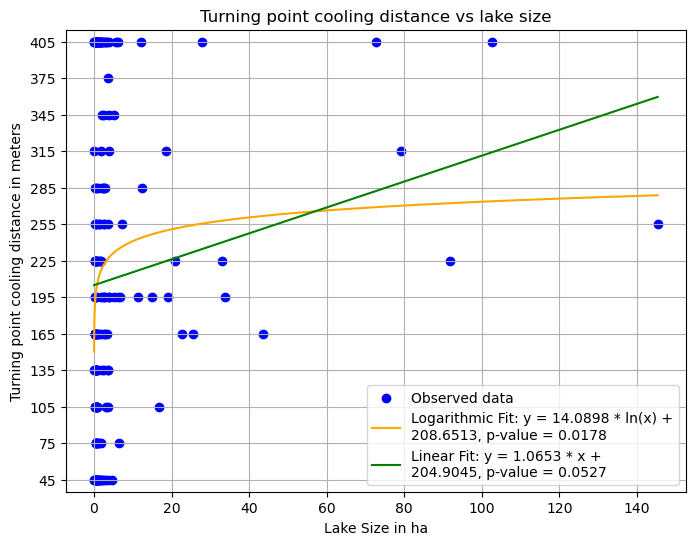

P-value for the logarithmic fit: 0.0178
The logarithmic fit formula is: y = 14.0898 * ln(x) + 208.6513
P-value for the linear fit: 0.0527
The linear fit formula is: y = 1.0653 * x + 204.9045


In [61]:
### Analysis 7A: Turning point distance to bin 0-30 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(0, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# List to store turning points and corresponding lake sizes
turning_points = []
lake_sizes = []

# Initialize figure for plotting both fits
plt.figure(figsize=(8, 6))

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    mask = base_mask & (lake_dist > 0)
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = delta_lst[first_bin_index] if not np.isnan(delta_lst[first_bin_index]) else np.nan

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    for i in range(1, len(mean_lst_values)):
        if mean_lst_values[i] < mean_lst_values[i - 1]:  
            break  
        turning_point_index = i  

    if turning_point_index >= 0:
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Plot the turning points vs lake size as a scatter plot
plt.scatter(lake_sizes, turning_points, c='blue', marker='o', label="Observed data")

# Logarithmic Fit
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, turning_points)

# Plot the fitted logarithmic curve
x_vals_log = np.linspace(min(log_lake_sizes), max(log_lake_sizes), 100)
y_vals_log = slope_log * x_vals_log + intercept_log  # Logarithmic fit line
plt.plot(np.exp(x_vals_log), y_vals_log, color='orange', label=f"Logarithmic Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p-value = {p_value_log:.4f}")

# Linear Fit
slope_lin, intercept_lin, r_value_lin, p_value_lin, std_err_lin = stats.linregress(lake_sizes, turning_points)

# Plot the fitted linear trend
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_lin * x_vals_lin + intercept_lin
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_lin:.4f} * x +\n{intercept_lin:.4f}, p-value = {p_value_lin:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling distance in meters")
plt.title("Turning point cooling distance vs lake size")

# Adjust y-axis
plt.ylim(min(turning_points) - 10, max(turning_points) + 10)  
plt.yticks(np.unique(turning_points))

# Show grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

plt.savefig("Fig7A_turningPointDistance0VSlakeSize.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Print results for both fits
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_lin:.4f}")
print(f"The linear fit formula is: y = {slope_lin:.4f} * x + {intercept_lin:.4f}")


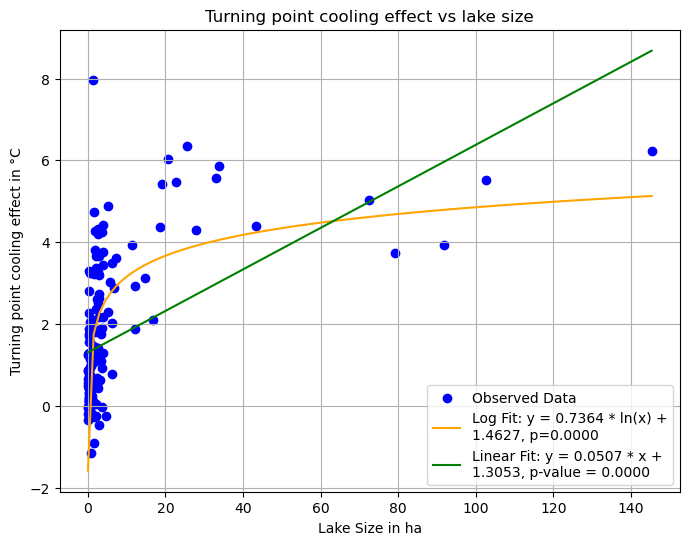

P-value for the logarithmic fit: 0.0000
The logarithmic fit formula is: y = 0.7364 * ln(x) + 1.4627
P-value for the linear fit: 0.0000
The linear fit formula is: y = 0.0507 * x + 1.3053


In [65]:
### Analysis 7B: Mean LST increase at turning point from bin 0-30 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(0, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    mask = base_mask & (lake_dist > 0)
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = delta_lst[first_bin_index] if not np.isnan(delta_lst[first_bin_index]) else np.nan

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    for i in range(1, len(mean_lst_values)):
        if mean_lst_values[i] < mean_lst_values[i - 1]:  
            break  
        turning_point_index = i  

    if turning_point_index >= 0:
        # Compute mean increase in LST from bin 1 to turning point
        lst_values_to_avg = delta_lst[first_bin_index:turning_point_index + 1]
        lst_values_to_avg = [val for val in lst_values_to_avg if not np.isnan(val)]  # Remove NaNs
        mean_lst_increase = np.mean(lst_values_to_avg) if len(lst_values_to_avg) > 0 else np.nan

        if not np.isnan(mean_lst_increase):
            mean_LST_increases.append(mean_lst_increase)
            lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, mean_LST_increases, c='blue', marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling effect in °C")
plt.title("Turning point cooling effect vs lake size")

# Display grid and legend
plt.grid(True)
plt.legend()  # This will automatically pull the correct labels from the plot elements

plt.savefig("Fig7B_turningPointlst0VSlakeSize.png", dpi=300, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")
print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


<Figure size 800x600 with 0 Axes>

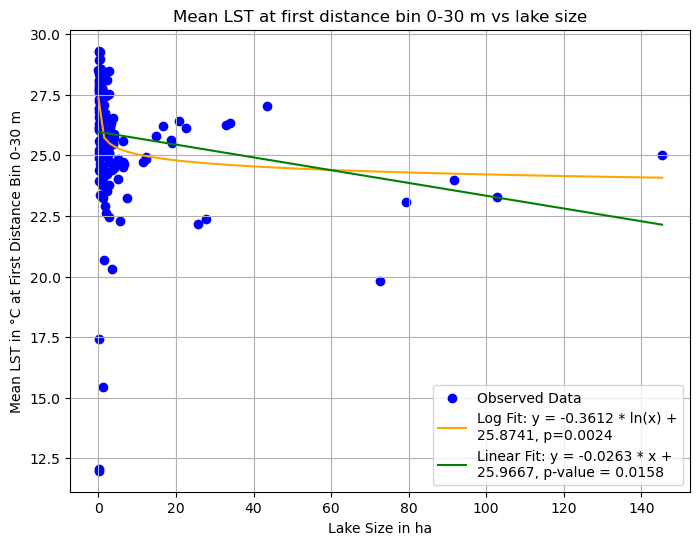

P-value for the logarithmic fit: 0.0024
The logarithmic fit formula is: y = -0.3612 * ln(x) + 25.8741
P-value for the linear fit: 0.0158
The linear fit formula is: y = -0.0263 * x + 25.9667


In [123]:
### Analysis 7C: Mean LST at lake distance to bin 0-30 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(0, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
first_bin_LSTs = []  # Mean LST at first bin (30-60m)
lake_sizes = []

plt.figure(figsize=(8, 6))  # Initialize figure

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    mask = base_mask & (lake_dist > 0)
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is part of this due to the bin start of 0 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    delta_lst = [val - lst_at_0 if not np.isnan(val) else np.nan for val in mean_lst_values]

    first_bin_index = 1  
    first_bin_lst = mean_lst_values[first_bin_index] if not np.isnan(mean_lst_values[first_bin_index]) else np.nan

    if not np.isnan(first_bin_lst):
        first_bin_LSTs.append(first_bin_lst)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
first_bin_LSTs = np.array(first_bin_LSTs)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, first_bin_LSTs)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, first_bin_LSTs)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, first_bin_LSTs, c='blue', marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Mean LST in °C at First Distance Bin 0-30 m")
plt.title("Mean LST at first distance bin 0-30 m vs lake size")

# Display grid and legend
plt.grid(True)
plt.legend(loc='lower right')  # This will automatically pull the correct labels from the plot elements

plt.savefig("Fig7C_firstdistbandlst0VSlakeSize.png", dpi=300, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")
print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


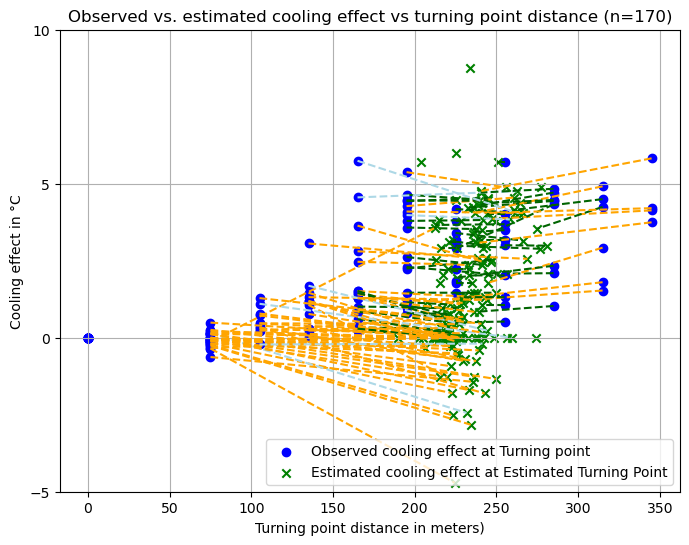

In [54]:
### Analysis 8A: Estimated vs. observed turning points in relation to bin 30-60 
## Approach for estimation: 
# Turning point distance from bin 30-60 is being calculated 
# Turning point LST increase from bin 30-60 is being calculated 
# LST at the turning point is being observed and used to measure LST at bin 30-60 as observed LST_turning_point minus estimated turning_point_LST_increase 
# Cooling effect is being plotted

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
threshold_distances = []  # To store calculated turning point distances
lst_at_turning_point_list = []  # To store the estimated LST at turning point distances
lst_est_at_30_60_list = []
lake_sizes = []  # To store lake sizes
bin_0_LSTs = []  # Mean LST at bin 0-30
obs_threshold_distances = []  # To store observed turning point distances
obs_lst_at_turning_point_list = []  # To store the observed LST at turning point distances

obs_threshold_distances_for_stat = []  # To store observed turning point distances
est_threshold_distances_for_stat = []  # To store observed turning point distances
obs_threshold_lst_for_stat = []  # To store observed turning point distances
est_threshold_lst_for_stat = []  # To store observed turning point distances

rows = []

plt.figure(figsize=(8, 6))  # Initialize figure

label_index = 1

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST at bin 0-30m (= dist=0)
    bin_0_mask = base_mask & (lake_dist < 30)  # Select points in the first bin (0-30m)
    bin_0_lst = np.mean(lst[bin_0_mask]) if np.any(bin_0_mask) else np.nan
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    if not np.isnan(lst_at_30_60):
        bin_0_LSTs.append(lst_at_30_60)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

        # Apply the logarithmic fit for turning point distance from bin 30-60:
        # y = 10.0069 * ln(x) + 231.2570
        lake_size = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0]
        threshold_distance = 10.0069 * np.log(lake_size) + 231.2570
        threshold_distances.append(threshold_distance)

        # Apply the logarithmic fit for mean LST increase from bin 30-60:
        # y = 0.8209 * ln(x) + 1.7238
        mean_lst_increase = 0.8209 * np.log(lake_size) + 1.7238

        # Calculate the estimated LST at bin 30-60
        if threshold_distance >= 60 and threshold_distance < 90: 
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 60) & (lake_dist < 90)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 90 and threshold_distance < 120:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 90) & (lake_dist < 120)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 120 and threshold_distance < 150:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 120) & (lake_dist < 150)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 150 and threshold_distance < 180:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 150) & (lake_dist < 180)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 180 and threshold_distance < 210:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 180) & (lake_dist < 210)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 210 and threshold_distance < 240:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 210) & (lake_dist < 240)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 240 and threshold_distance < 270:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 240) & (lake_dist < 270)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 270 and threshold_distance < 300:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 270) & (lake_dist < 300)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 300 and threshold_distance < 330:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 300) & (lake_dist < 330)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 330 and threshold_distance < 360:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 330) & (lake_dist < 360)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 360 and threshold_distance < 390:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 360) & (lake_dist < 390)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 390 and threshold_distance < 420:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 390) & (lake_dist < 420)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan

        lst_est_at_30_60 = lst_at_turning_point - mean_lst_increase
        #print("observe outliers: ", lst_est_at_30_60, lst_at_turning_point, mean_lst_increase)
        lst_est_at_30_60_list.append(lst_est_at_30_60)

        lst_at_threshold = lst_at_turning_point
        lst_at_turning_point_list.append(lst_at_threshold)

    else: 
        threshold_distance = np.nan
        threshold_distances.append(threshold_distance)
        lst_est_at_30_60 = np.nan
        lst_est_at_30_60_list.append(lst_est_at_30_60)      
        lst_at_threshold = np.nan
        lst_at_turning_point_list.append(lst_at_threshold)
 
    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    # Compute the slope between successive bins
    slopes = np.diff(mean_lst_values) / np.diff(bin_labels)

    # Find turning point (last increasing point before a decrease)
    turning_point_index = np.argmax(slopes < 0)

    if turning_point_index > 0:
        turning_point_distance = bin_labels[turning_point_index]
    else:
        turning_point_distance = np.nan
    obs_threshold_distances.append(turning_point_distance)

    # Get LST at the turning point
    turning_point_lst = delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan
    if turning_point_lst == 0: 
        print("is zero")
        if turning_point_distance > 0: 
            print("test ", delta_lst, turning_point_index) 
    obs_lst_at_turning_point_list.append(lst_at_30_60+turning_point_lst)

    # If any of the values are NaN, replace them with zero
    obs_dist_value = turning_point_distance if not np.isnan(turning_point_distance) else 0
    obs_lst30_60_value = lst_at_30_60 if not np.isnan(lst_at_30_60) else 0
    obs_lst_value = lst_at_30_60+turning_point_lst if not np.isnan(lst_at_30_60+turning_point_lst) else 0
    obs_lst_dif_value = turning_point_lst if not np.isnan(turning_point_lst) else 0
    est_dist_value = threshold_distance if not np.isnan(threshold_distance) else 0
    est_lst30_60_value = lst_est_at_30_60 if not np.isnan(lst_est_at_30_60) else 0
    est_lst_value = lst_at_threshold if not np.isnan(lst_at_threshold) else 0
    est_lst_dif_value = lst_at_threshold-lst_at_30_60 if not np.isnan(lst_at_threshold-lst_at_30_60) else 0
    if obs_lst_value == 0 and obs_dist_value > 0: 
        obs_dist_value = 0 # if first band is nan we do not count include the lake 
    elif obs_lst_value == 0 and obs_dist_value == 0 and est_dist_value == 0 and est_lst_value == 0:
        obs_dist_value = 0 # if all is zero we do not include the lake 
    else: 
        # Append the row as a dictionary
        rows.append({
            'id': lake_id,
            'obs_dist': obs_dist_value,
            'obs_lst30_60': obs_lst30_60_value,
            'obs_lst': obs_lst_value,
            'obs_lst_dif': obs_lst_dif_value,
            'est_dist': est_dist_value,
            'est_lst30_60': est_lst30_60_value,
            'est_lst': est_lst_value,
            'est_lst_dif': est_lst_dif_value
        })
        if label_index == 1: 
            # Plot the observed cooling effects (blue dots)
            plt.scatter(obs_dist_value,  obs_lst_dif_value, c='blue', marker='o', label="Observed cooling effect at Turning point")
    
            # Plot estimated cooling effects
            plt.scatter(est_dist_value, est_lst_dif_value, c='green', marker='x', label="Estimated cooling effect at Estimated Turning Point")
    
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue 
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif abs(obs_dist_value - est_dist_value) <= 60:
                plt.plot([obs_dist_value, est_dist_value], 
                         [obs_lst_dif_value, est_lst_dif_value], color='darkgreen', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_dif_value, est_lst_dif_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_dif_value, est_lst_dif_value], color='orange', linestyle='--', label=None)            
            label_index += 1
        else: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst_dif_value, c='blue', marker='o', label=None)
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst_dif_value, c='green', marker='x', label=None)

            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif abs(obs_dist_value - est_dist_value) <= 60:
                plt.plot([obs_dist_value, est_dist_value], 
                         [obs_lst_dif_value, est_lst_dif_value], color='darkgreen', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_dif_value, est_lst_dif_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_dif_value, est_lst_dif_value], color='orange', linestyle='--', label=None)
                
        if obs_dist_value > 0 and est_dist_value > 0: 
            obs_threshold_distances_for_stat.append(obs_dist_value)  
            est_threshold_distances_for_stat.append(est_dist_value)
        if obs_lst_value > 0 and est_lst_value > 0: 
            obs_threshold_lst_for_stat.append(obs_lst30_60_value)  
            est_threshold_lst_for_stat.append(est_lst30_60_value)
        

# Convert lists to numpy arrays for plotting
threshold_distances = np.array(threshold_distances)
lst_at_turning_point_list = np.array(lst_at_turning_point_list)
observed_distances = np.array(obs_threshold_distances)
observed_lsts = np.array(obs_lst_at_turning_point_list)

obs_threshold_distances_for_stat = np.array(obs_threshold_distances_for_stat)
est_threshold_distances_for_stat = np.array(est_threshold_distances_for_stat)
obs_threshold_lst_for_stat = np.array(obs_threshold_lst_for_stat)
est_threshold_lst_for_stat = np.array(est_threshold_lst_for_stat)

# Set axis labels and title
plt.xlabel("Turning point distance in meters)")
plt.ylabel("Cooling effect in °C")
yticks = np.arange(-5, 55, 5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.ylim(-5, 10)

plt.title("Observed vs. estimated cooling effect vs turning point distance (n=170)")

plt.grid(True)
plt.legend(loc='lower right')

plt.savefig("Fig8A_lakes_est_obs_turningpoints.png", dpi=300, bbox_inches="tight")

plt.show()

# Convert the list of rows into a DataFrame
ids_with_values = pd.DataFrame(rows)
ids_with_values.to_csv('lakes_with_turning_points_Fig8A.csv', index=False)


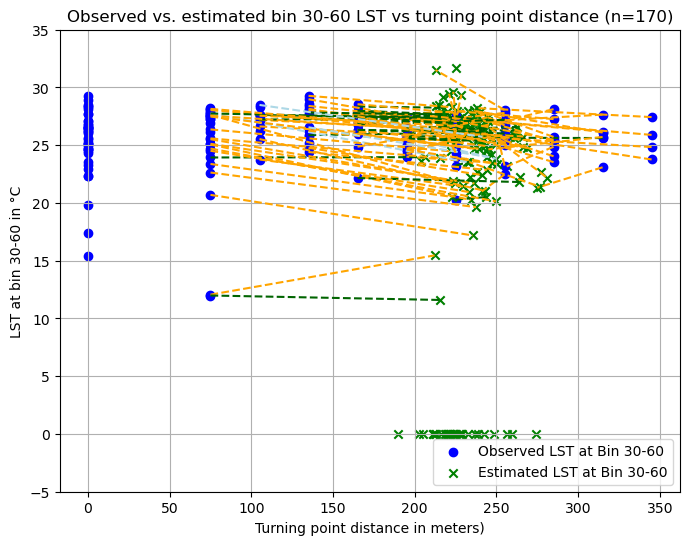

In [46]:
### Analysis 8B: Estimated vs. observed turning points in relation to bin 30-60 
## Approach for estimation: 
# Turning point distance from bin 30-60 is being calculated 
# Turning point LST increase from bin 30-60 is being calculated 
# LST at the turning point is being observed and used to measure LST at bin 30-60 as observed LST_turning_point minus estimated turning_point_LST_increase 
# Estimated 30-60 bin LST is being plotted

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
threshold_distances = []  # To store calculated turning point distances
lst_at_turning_point_list = []  # To store the estimated LST at turning point distances
lst_est_at_30_60_list = []
lake_sizes = []  # To store lake sizes
bin_0_LSTs = []  # Mean LST at bin 0-30
obs_threshold_distances = []  # To store observed turning point distances
obs_lst_at_turning_point_list = []  # To store the observed LST at turning point distances

obs_threshold_distances_for_stat = []  # To store observed turning point distances
est_threshold_distances_for_stat = []  # To store observed turning point distances
obs_threshold_lst_for_stat = []  # To store observed turning point distances
est_threshold_lst_for_stat = []  # To store observed turning point distances

rows = []

plt.figure(figsize=(8, 6))  # Initialize figure

label_index = 1

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST at bin 0-30m (= dist=0)
    bin_0_mask = base_mask & (lake_dist < 30)  # Select points in the first bin (0-30m)
    bin_0_lst = np.mean(lst[bin_0_mask]) if np.any(bin_0_mask) else np.nan
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    if not np.isnan(lst_at_30_60):
        bin_0_LSTs.append(lst_at_30_60)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

        # Apply the logarithmic fit for turning point distance from bin 30-60:
        # y = 10.0069 * ln(x) + 231.2570
        lake_size = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0]
        threshold_distance = 10.0069 * np.log(lake_size) + 231.2570
        threshold_distances.append(threshold_distance)

        # Apply the logarithmic fit for mean LST increase from bin 30-60:
        # y = 0.8209 * ln(x) + 1.7238
        mean_lst_increase = 0.8209 * np.log(lake_size) + 1.7238

        # Calculate the estimated LST at bin 30-60
        if threshold_distance >= 60 and threshold_distance < 90: 
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 60) & (lake_dist < 90)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 90 and threshold_distance < 120:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 90) & (lake_dist < 120)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 120 and threshold_distance < 150:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 120) & (lake_dist < 150)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 150 and threshold_distance < 180:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 150) & (lake_dist < 180)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 180 and threshold_distance < 210:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 180) & (lake_dist < 210)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 210 and threshold_distance < 240:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 210) & (lake_dist < 240)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 240 and threshold_distance < 270:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 240) & (lake_dist < 270)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 270 and threshold_distance < 300:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 270) & (lake_dist < 300)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 300 and threshold_distance < 330:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 300) & (lake_dist < 330)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 330 and threshold_distance < 360:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 330) & (lake_dist < 360)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 360 and threshold_distance < 390:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 360) & (lake_dist < 390)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan
        elif threshold_distance >= 390 and threshold_distance < 420:
            # Compute mean LST for dist = turning point (used as reference)
            lst_at_mask = base_mask & (lake_dist >= 390) & (lake_dist < 420)
            lst_at_turning_point = np.nanmean(lst[lst_at_mask]) if np.any(lst_at_mask) else np.nan

        lst_est_at_30_60 = lst_at_turning_point - mean_lst_increase
        #print("observe outliers: ", lst_est_at_30_60, lst_at_turning_point, mean_lst_increase)
        lst_est_at_30_60_list.append(lst_est_at_30_60)

        lst_at_threshold = lst_at_turning_point
        lst_at_turning_point_list.append(lst_at_threshold)

    else: 
        threshold_distance = np.nan
        threshold_distances.append(threshold_distance)
        lst_est_at_30_60 = np.nan
        lst_est_at_30_60_list.append(lst_est_at_30_60)      
        lst_at_threshold = np.nan
        lst_at_turning_point_list.append(lst_at_threshold)
 
    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    # Compute the slope between successive bins
    slopes = np.diff(mean_lst_values) / np.diff(bin_labels)

    # Find turning point (last increasing point before a decrease)
    turning_point_index = np.argmax(slopes < 0)

    if turning_point_index > 0:
        turning_point_distance = bin_labels[turning_point_index]
    else:
        turning_point_distance = np.nan
    obs_threshold_distances.append(turning_point_distance)

    # Get LST at the turning point
    turning_point_lst = delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan
    if turning_point_lst == 0: 
        print("is zero")
        if turning_point_distance > 0: 
            print("test ", delta_lst, turning_point_index) 
    obs_lst_at_turning_point_list.append(lst_at_30_60+turning_point_lst)

    # If any of the values are NaN, replace them with zero
    obs_dist_value = turning_point_distance if not np.isnan(turning_point_distance) else 0
    obs_lst30_60_value = lst_at_30_60 if not np.isnan(lst_at_30_60) else 0
    obs_lst_value = lst_at_30_60+turning_point_lst if not np.isnan(lst_at_30_60+turning_point_lst) else 0
    obs_lst_dif_value = turning_point_lst if not np.isnan(turning_point_lst) else 0
    est_dist_value = threshold_distance if not np.isnan(threshold_distance) else 0
    est_lst30_60_value = lst_est_at_30_60 if not np.isnan(lst_est_at_30_60) else 0
    est_lst_value = lst_at_threshold if not np.isnan(lst_at_threshold) else 0
    est_lst_dif_value = lst_at_threshold-lst_at_30_60 if not np.isnan(lst_at_threshold-lst_at_30_60) else 0
    if obs_lst_value == 0 and obs_dist_value > 0: 
        obs_dist_value = 0 # if first band is nan we do not count include the lake 
    elif obs_lst_value == 0 and obs_dist_value == 0 and est_dist_value == 0 and est_lst_value == 0:
        obs_dist_value = 0 # if all is zero we do not include the lake 
    else: 
        # Append the row as a dictionary
        rows.append({
            'id': lake_id,
            'obs_dist': obs_dist_value,
            'obs_lst30_60': obs_lst30_60_value,
            'obs_lst': obs_lst_value,
            'obs_lst_dif': obs_lst_dif_value,
            'est_dist': est_dist_value,
            'est_lst30_60': est_lst30_60_value,
            'est_lst': est_lst_value,
            'est_lst_dif': est_lst_dif_value
        })
        if label_index == 1: 
            # Plot the observed cooling effects (blue dots)
            plt.scatter(obs_dist_value,  obs_lst30_60_value, c='blue', marker='o', label="Observed LST at Bin 30-60")
    
            # Plot estimated cooling effects
            plt.scatter(est_dist_value, est_lst30_60_value, c='green', marker='x', label="Estimated LST at Bin 30-60")
    
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue 
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif est_lst30_60_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif abs(obs_lst30_60_value - est_lst30_60_value) <= 0.5:
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='darkgreen', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='orange', linestyle='--', label=None)

            label_index += 1
        else: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst30_60_value, c='blue', marker='o', label=None)
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst30_60_value, c='green', marker='x', label=None)

            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif est_lst30_60_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif abs(obs_lst30_60_value - est_lst30_60_value) <= 0.5:
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='darkgreen', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst30_60_value, est_lst30_60_value], color='orange', linestyle='--', label=None)
                
        if obs_dist_value > 0 and est_dist_value > 0: 
            obs_threshold_distances_for_stat.append(obs_dist_value)  
            est_threshold_distances_for_stat.append(est_dist_value)
        if obs_lst_value > 0 and est_lst_value > 0: 
            obs_threshold_lst_for_stat.append(obs_lst30_60_value)  
            est_threshold_lst_for_stat.append(est_lst30_60_value)
        

# Convert lists to numpy arrays for plotting
threshold_distances = np.array(threshold_distances)
lst_at_turning_point_list = np.array(lst_at_turning_point_list)
observed_distances = np.array(obs_threshold_distances)
observed_lsts = np.array(obs_lst_at_turning_point_list)

obs_threshold_distances_for_stat = np.array(obs_threshold_distances_for_stat)
est_threshold_distances_for_stat = np.array(est_threshold_distances_for_stat)
obs_threshold_lst_for_stat = np.array(obs_threshold_lst_for_stat)
est_threshold_lst_for_stat = np.array(est_threshold_lst_for_stat)

# Set axis labels and title
plt.xlabel("Turning point distance in meters)")
plt.ylabel("LST at bin 30-60 in °C")
yticks = np.arange(-5, 55, 5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.ylim(-5, 35)

plt.title("Observed vs. estimated bin 30-60 LST vs turning point distance (n=170)")

plt.grid(True)
plt.legend(loc='lower right')

plt.savefig("Fig8B_lakes_est_obs_turningpoints.png", dpi=300, bbox_inches="tight")

plt.show()

# Convert the list of rows into a DataFrame
ids_with_values = pd.DataFrame(rows)
ids_with_values.to_csv('lakes_with_turning_points_Fig8B.csv', index=False)


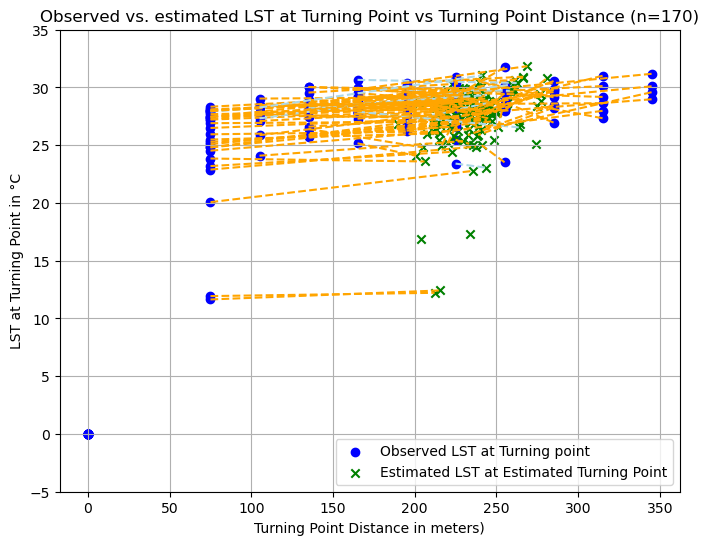

In [99]:
### Analysis 8C: Estimated vs. observed turning points in relation to bin 30-60 version 2
## Approach for estimation: 
# Turning point distance from bin 30-60 is being calculated 
# Turning point LST increase from bin 30-60 is being calculated 
# LST at-the lake bin 30-60 is being observed and used to measure LST at the turning point as observed LST_0_30 plus estimated turning_point_LST_increase 
# Estimated 30-60 bin LST is being plotted 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
threshold_distances = []  # To store calculated turning point distances
lst_at_turning_point_list = []  # To store the estimated LST at turning point distances
lake_sizes = []  # To store lake sizes
bin_0_LSTs = []  # Mean LST at bin 0-30
obs_threshold_distances = []  # To store observed turning point distances
obs_lst_at_turning_point_list = []  # To store the observed LST at turning point distances

obs_threshold_distances_for_stat = []  # To store observed turning point distances
est_threshold_distances_for_stat = []  # To store observed turning point distances
obs_threshold_lst_for_stat = []  # To store observed turning point distances
est_threshold_lst_for_stat = []  # To store observed turning point distances

rows = []

plt.figure(figsize=(8, 6))  # Initialize figure

label_index = 1

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST at bin 0-30m (= dist=0)
    bin_0_mask = base_mask & (lake_dist < 30)  # Select points in the first bin (0-30m)
    bin_0_lst = np.mean(lst[bin_0_mask]) if np.any(bin_0_mask) else np.nan
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    if not np.isnan(lst_at_30_60):
        bin_0_LSTs.append(lst_at_30_60)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

        # Apply the logarithmic fit for turning point distance from bin 30-60:
        # y = 10.0069 * ln(x) + 231.2570
        lake_size = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0]
        threshold_distance = 10.0069 * np.log(lake_size) + 231.2570
        threshold_distances.append(threshold_distance)

        # Apply the logarithmic fit for mean LST increase from bin 30-60:
        # y = 0.8209 * ln(x) + 1.7238
        mean_lst_increase = 0.8209 * np.log(lake_size) + 1.7238

        lst_at_threshold = lst_at_30_60+mean_lst_increase

        lst_at_turning_point_list.append(lst_at_threshold)

    else: 
        threshold_distance = np.nan
        threshold_distances.append(threshold_distance)
        lst_at_threshold = np.nan
        lst_at_turning_point_list.append(lst_at_threshold)
 
    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    # Compute the slope between successive bins
    slopes = np.diff(mean_lst_values) / np.diff(bin_labels)

    # Find turning point (last increasing point before a decrease)
    turning_point_index = np.argmax(slopes < 0)

    if turning_point_index > 0:
        turning_point_distance = bin_labels[turning_point_index]
    else:
        turning_point_distance = np.nan
    obs_threshold_distances.append(turning_point_distance)

    # Get LST at the turning point
    turning_point_lst = delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan
    if turning_point_lst == 0: 
        print("is zero")
        if turning_point_distance > 0: 
            print("test ", delta_lst, turning_point_index) 
    obs_lst_at_turning_point_list.append(lst_at_30_60+turning_point_lst)

    # If any of the values are NaN, replace them with zero
    obs_dist_value = turning_point_distance if not np.isnan(turning_point_distance) else 0
    obs_lst_value = lst_at_30_60+turning_point_lst if not np.isnan(lst_at_30_60+turning_point_lst) else 0
    obs_lst_dif_value = turning_point_lst if not np.isnan(turning_point_lst) else 0
    est_dist_value = threshold_distance if not np.isnan(threshold_distance) else 0
    est_lst_value = lst_at_threshold if not np.isnan(lst_at_threshold) else 0
    est_lst_dif_value = mean_lst_increase if not np.isnan(mean_lst_increase) else 0
    if obs_lst_value == 0 and obs_dist_value > 0: 
        obs_dist_value = 0 # if first band is nan we do not count include the lake 
    elif obs_lst_value == 0 and obs_dist_value == 0 and est_dist_value == 0 and est_lst_value == 0:
        obs_dist_value = 0 # if all is zero we do not include the lake 
    else: 
        # Append the row as a dictionary
        rows.append({
            'id': lake_id,
            'obs_dist': obs_dist_value,
            'obs_lst30_60': obs_lst30_60_value,
            'obs_lst': obs_lst_value,
            'obs_lst_dif': obs_lst_dif_value,
            'est_dist': est_dist_value,
            'est_lst30_60': est_lst30_60_value,
            'est_lst': est_lst_value,
            'est_lst_dif': est_lst_dif_value
        })
        if label_index == 1: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst_value, c='blue', marker='o', label="Observed LST at Turning point")
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst_value, c='green', marker='x', label="Estimated LST at Estimated Turning Point")
    
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue 
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='orange', linestyle='--', label=None)

            label_index += 1
        else: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst_value, c='blue', marker='o', label=None)
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst_value, c='green', marker='x', label=None)

            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='orange', linestyle='--', label=None)
                
        if obs_dist_value > 0 and est_dist_value > 0: 
            obs_threshold_distances_for_stat.append(obs_dist_value)  
            est_threshold_distances_for_stat.append(est_dist_value)
        if obs_lst_value > 0 and est_lst_value > 0: 
            obs_threshold_lst_for_stat.append(obs_lst_value)  
            est_threshold_lst_for_stat.append(est_lst_value)
        

# Convert lists to numpy arrays for plotting
threshold_distances = np.array(threshold_distances)
lst_at_turning_point_list = np.array(lst_at_turning_point_list)
observed_distances = np.array(obs_threshold_distances)
observed_lsts = np.array(obs_lst_at_turning_point_list)

obs_threshold_distances_for_stat = np.array(obs_threshold_distances_for_stat)
est_threshold_distances_for_stat = np.array(est_threshold_distances_for_stat)
obs_threshold_lst_for_stat = np.array(obs_threshold_lst_for_stat)
est_threshold_lst_for_stat = np.array(est_threshold_lst_for_stat)

# Set axis labels and title
plt.xlabel("Turning Point Distance in meters)")
plt.ylabel("LST at Turning Point in °C")
yticks = np.arange(-5, 55, 5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.ylim(-5, 35)

plt.title("Observed vs. estimated LST at Turning Point vs Turning Point Distance (n=170)")

plt.grid(True)
plt.legend(loc='lower right')

plt.savefig("Fig8C_lakes_est_obs_turningpoints.png", dpi=300, bbox_inches="tight")

plt.show()

# Convert the list of rows into a DataFrame
ids_with_values = pd.DataFrame(rows)
ids_with_values.to_csv('lakes_with_turning_points_Fig8C.csv', index=False)


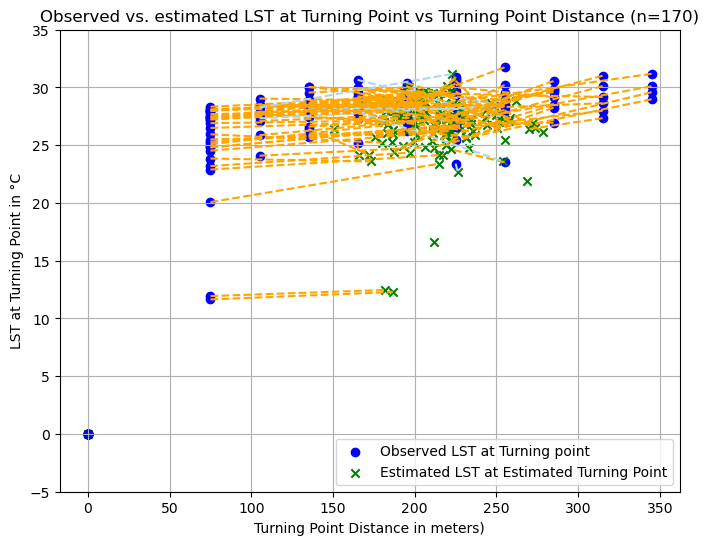

In [101]:
### Analysis 8D: Estimated vs. observed turning points in relation to bin 0-30
## Approach for estimation: 
# Turning point distance from bin 0-30 is being calculated 
# Turning point LST increase from bin 0-30 is being calculated 
# LST at-the lake bin 0-30 is being observed and used to measure LST at the turning point as observed LST_0_30 plus estimated turning_point_LST_increase 
# Estimated turning point LST in relation to bin 0-30 is being plotted 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Replace with actual observed data
#observed_distances = np.array([100, 150, 200, 250, 300])  # Example observed turnning point distances (m)
#observed_lsts = np.array([22.0, 23.5, 24.0, 24.5, 25.0])  # Example observed LST at turning point (°C)

# Lists to store results
threshold_distances = []  # To store calculated turning point distances
lst_at_turning_point_list = []  # To store the estimated LST at turning point distances
lake_sizes = []  # To store lake sizes
bin_0_LSTs = []  # Mean LST at bin 0-30
obs_threshold_distances = []  # To store observed turning point distances
obs_lst_at_turning_point_list = []  # To store the observed LST at turning point distances

obs_threshold_distances_for_stat = []  # To store observed turning point distances
est_threshold_distances_for_stat = []  # To store observed turning point distances
obs_threshold_lst_for_stat = []  # To store observed turning point distances
est_threshold_lst_for_stat = []  # To store observed turning point distances

rows = []

plt.figure(figsize=(8, 6))  # Initialize figure

label_index = 1

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST at bin 0-30m (= dist=0)
    bin_0_mask = base_mask & (lake_dist < 30)  # Select points in the first bin (0-30m)
    bin_0_lst = np.mean(lst[bin_0_mask]) if np.any(bin_0_mask) else np.nan

    if not np.isnan(bin_0_lst):
        bin_0_LSTs.append(bin_0_lst)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])

        # Apply the logarithmic fit for turning point distance:
        # y = 14.0898 * ln(x) + 208.6513
        lake_size = lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0]
        threshold_distance = 14.0898 * np.log(lake_size) + 208.6513
        threshold_distances.append(threshold_distance)

        # Apply the logarithmic fit for mean LST increase:
        # y = 0.7364 * ln(x) + 1.4627
        mean_lst_increase = 0.7364 * np.log(lake_size) + 1.4627

        # Calculate the estimated LST at turning point
        lst_at_threshold = bin_0_lst + mean_lst_increase
        lst_at_turning_point_list.append(lst_at_threshold)

    else: 
        threshold_distance = np.nan
        threshold_distances.append(threshold_distance)
        lst_at_threshold = np.nan
        lst_at_turning_point_list.append(lst_at_threshold)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    # Compute the slope between successive bins
    slopes = np.diff(mean_lst_values) / np.diff(bin_labels)

    # Find turning point (last increasing point before a decrease)
    turning_point_index = np.argmax(slopes < 0)

    if turning_point_index > 0:
        turning_point_distance = bin_labels[turning_point_index]
    else:
        turning_point_distance = np.nan
    obs_threshold_distances.append(turning_point_distance)

    # Get LST at the turning point
    turning_point_lst = delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan
    if turning_point_lst == 0: 
        print("is zero")
        if turning_point_distance > 0: 
            print("test ", delta_lst, turning_point_index) 
    obs_lst_at_turning_point_list.append(lst_at_30_60+turning_point_lst)

    # If any of the values are NaN, replace them with zero
    obs_dist_value = turning_point_distance if not np.isnan(turning_point_distance) else 0
    obs_lst_value = lst_at_30_60+turning_point_lst if not np.isnan(lst_at_30_60+turning_point_lst) else 0
    obs_lst_dif_value = turning_point_lst if not np.isnan(lst_at_30_60+turning_point_lst) else 0
    est_dist_value = threshold_distance if not np.isnan(threshold_distance) else 0
    est_lst_value = lst_at_threshold if not np.isnan(lst_at_threshold) else 0
    est_lst_dif_value = lst_at_threshold-lst_at_30_60 if not np.isnan(lst_at_threshold-lst_at_30_60) else 0
    if obs_lst_value == 0 and obs_dist_value > 0: 
        obs_dist_value = 0 # if first band is nan we do not count include the lake 
    elif obs_lst_value == 0 and obs_dist_value == 0 and est_dist_value == 0 and est_lst_value == 0:
        obs_dist_value = 0 # if all is zero we do not include the lake 
    else: 
        # Append the row as a dictionary
        rows.append({
            'id': lake_id,
            'obs_dist': obs_dist_value,
            'obs_lst': obs_lst_value,
            'obs_lst_dif': obs_lst_dif_value,
            'est_dist': est_dist_value,
            'est_lst': est_lst_value,
            'est_lst_dif': est_lst_dif_value
        })
        if label_index == 1: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst_value, c='blue', marker='o', label="Observed LST at Turning point")
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst_value, c='green', marker='x', label="Estimated LST at Estimated Turning Point")
    
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue 
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='orange', linestyle='--', label=None)

            label_index += 1
        else: 
            # Plot the observed turning points (blue dots)
            plt.scatter(obs_dist_value, obs_lst_value, c='blue', marker='o', label=None)
    
            # Plot estimated
            plt.scatter(est_dist_value, est_lst_value, c='green', marker='x', label=None)

            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if obs_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='red', linestyle='--', label=None)
            elif est_dist_value == 0: 
                continue
                # Loop through each lake and draw a line connecting observed and estimated points
                #plt.plot([obs_dist_value, est_dist_value], 
                #             [obs_lst_value, est_lst_value], color='darkred', linestyle='--', label=None)
            elif is_near_sea:
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='lightblue', linestyle='--', label=None)
            else: 
                # Loop through each lake and draw a line connecting observed and estimated points
                plt.plot([obs_dist_value, est_dist_value], 
                             [obs_lst_value, est_lst_value], color='orange', linestyle='--', label=None)
                
        if obs_dist_value > 0 and est_dist_value > 0: 
            obs_threshold_distances_for_stat.append(obs_dist_value)  
            est_threshold_distances_for_stat.append(est_dist_value)
        if obs_lst_value > 0 and est_lst_value > 0: 
            obs_threshold_lst_for_stat.append(obs_lst_value)  
            est_threshold_lst_for_stat.append(est_lst_value)
        

# Convert lists to numpy arrays for plotting
threshold_distances = np.array(threshold_distances)
lst_at_turning_point_list = np.array(lst_at_turning_point_list)
observed_distances = np.array(obs_threshold_distances)
observed_lsts = np.array(obs_lst_at_turning_point_list)

obs_threshold_distances_for_stat = np.array(obs_threshold_distances_for_stat)
est_threshold_distances_for_stat = np.array(est_threshold_distances_for_stat)
obs_threshold_lst_for_stat = np.array(obs_threshold_lst_for_stat)
est_threshold_lst_for_stat = np.array(est_threshold_lst_for_stat)

# Set axis labels and title
plt.xlabel("Turning Point Distance in meters)")
plt.ylabel("LST at Turning Point in °C")
yticks = np.arange(-5, 55, 5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.ylim(-5, 35)

plt.title("Observed vs. estimated LST at Turning Point vs Turning Point Distance (n=170)")

plt.grid(True)
plt.legend(loc='lower right')

plt.savefig("Fig8D_lakes_est_obs_turningpoints.png", dpi=300, bbox_inches="tight")

plt.show()

# Convert the list of rows into a DataFrame
ids_with_values = pd.DataFrame(rows)
ids_with_values.to_csv('lakes_with_turning_points8D.csv', index=False)


In [56]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
# For turning point distance
errors_distance = obs_threshold_distances_for_stat - est_threshold_distances_for_stat
MAE_distance = np.mean(np.abs(errors_distance))

# For LST at turning point
errors_lst = obs_threshold_lst_for_stat - est_threshold_lst_for_stat
MAE_distance = np.mean(np.abs(errors_distance))
MAE_lst = np.mean(np.abs(errors_lst))

print("MAE for distance:", MAE_distance)
print("MAE for LST:", MAE_lst)

MAE for distance: 81.12130577114996
MAE for LST: 1.4539233091709225


In [58]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
RMSE_distance = np.sqrt(np.mean(errors_distance**2))
RMSE_lst = np.sqrt(np.mean(errors_lst**2))

print("RMSE for distance:", RMSE_distance)
print("RMSE for LST:", RMSE_lst)


RMSE for distance: 94.24044659688083
RMSE for LST: 1.876735579145458


In [60]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
bias_distance = np.mean(errors_distance)
bias_lst = np.mean(errors_lst)

print("Bias for distance:", bias_distance)
print("Bias for LST:", bias_lst)
#This negative bias (calculated as observed minus estimated) means that on average, the observed turning point distances are about 36.64 meters lower than the estimated ones. 
#In other words, your estimation method is, on average, overestimating the turning point distance by roughly 36.64 m
#Here the positive bias indicates that the observed LST values at the turning point are on average 0.63 °C higher than the estimated values. 
#This suggests that your estimation method slightly underpredicts the LST at the turning point.

Bias for distance: -59.052439925227496
Bias for LST: 0.49900034044070807


In [61]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
corr_distance = np.corrcoef(obs_threshold_distances_for_stat, est_threshold_distances_for_stat)[0, 1]
corr_lst = np.corrcoef(obs_threshold_lst_for_stat, est_threshold_lst_for_stat)[0, 1]

print("Correlation for distance:", corr_distance)
print("Correlation for LST:", corr_lst)



Correlation for distance: 0.37249576721295696
Correlation for LST: 0.8080832911136377


In [63]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
# For distance
X_distance = sm.add_constant(est_threshold_distances_for_stat)
model_distance = sm.OLS(obs_threshold_distances_for_stat, X_distance).fit()
print(model_distance.summary())

# For LST
X_lst = sm.add_constant(est_threshold_lst_for_stat)
model_lst = sm.OLS(obs_threshold_lst_for_stat, X_lst).fit()
print(model_lst.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     20.30
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           1.49e-05
Time:                        15:40:34   Log-Likelihood:                -729.10
No. Observations:                 128   AIC:                             1462.
Df Residuals:                     126   BIC:                             1468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -100.2160     61.490     -1.630      0.1

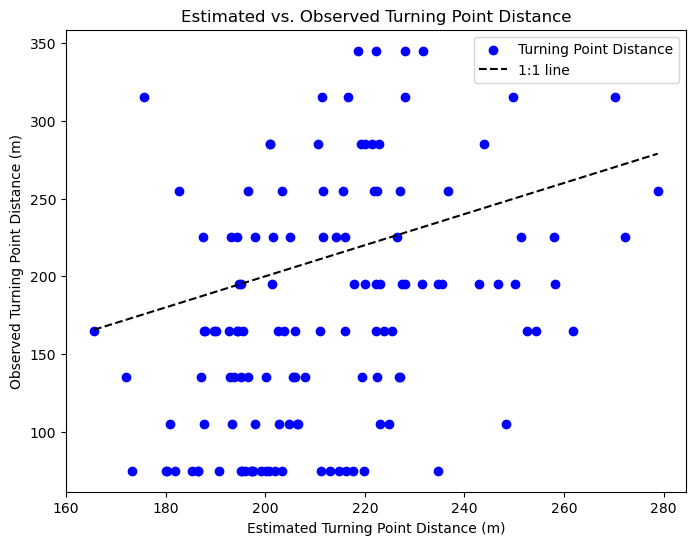

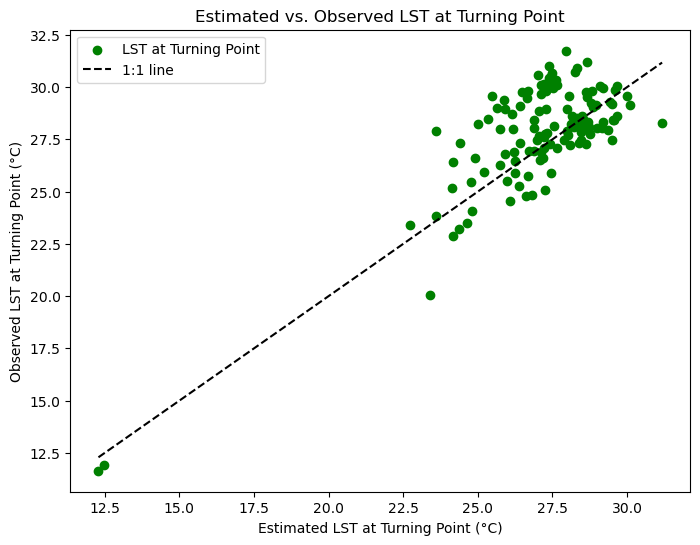

In [65]:
#EVALUATING ESTIMATED VS OBSERVED TURNING POINTS
# For distance
plt.figure(figsize=(8,6))
plt.scatter(est_threshold_distances_for_stat, obs_threshold_distances_for_stat, color='blue', label="Turning Point Distance")
plt.plot([min(est_threshold_distances_for_stat), max(est_threshold_distances_for_stat)],
         [min(est_threshold_distances_for_stat), max(est_threshold_distances_for_stat)], 'k--', label="1:1 line")
plt.xlabel("Estimated Turning Point Distance (m)")
plt.ylabel("Observed Turning Point Distance (m)")
plt.title("Estimated vs. Observed Turning Point Distance")
plt.legend()
plt.show()

# For LST
plt.figure(figsize=(8,6))
plt.scatter(est_threshold_lst_for_stat, obs_threshold_lst_for_stat, color='green', label="LST at Turning Point")
plt.plot([min(est_threshold_lst_for_stat), max(est_threshold_lst_for_stat)],
         [min(est_threshold_lst_for_stat), max(est_threshold_lst_for_stat)], 'k--', label="1:1 line")
plt.xlabel("Estimated LST at Turning Point (°C)")
plt.ylabel("Observed LST at Turning Point (°C)")
plt.title("Estimated vs. Observed LST at Turning Point")
plt.legend()
plt.show()


LST at Lakes Herb (0m): 25.03871815922571
LST at Lakes not Herb (0m): 25.62283132923495
Turning Point Distance Herb (last increasing point before decrease): 135 meters
Turning Point Distance not Herb (last increasing point before decrease): 405 meters
LST at First Bin Herb (30-60m): 25.30149980613144
LST at First Bin not Herb (30-60m): 26.027650282007897
LST at Turning Point Herb: 25.97594223566661
LST at Turning Point not Herb: 28.68808019441717
LST Increase Between First Bin (30-60m) and Turning Point Herb: 0.6744424295351715
LST Increase Between First Bin (30-60m) and Turning Point not Herb: 2.6604299124092754
P-value for logarithmic lakes with vegetation fit: 0.0001
The logarithmic fit is statistically significant.
P-value for logarithmic lakes without vegetation fit: 0.0000
The logarithmic fit is statistically significant.


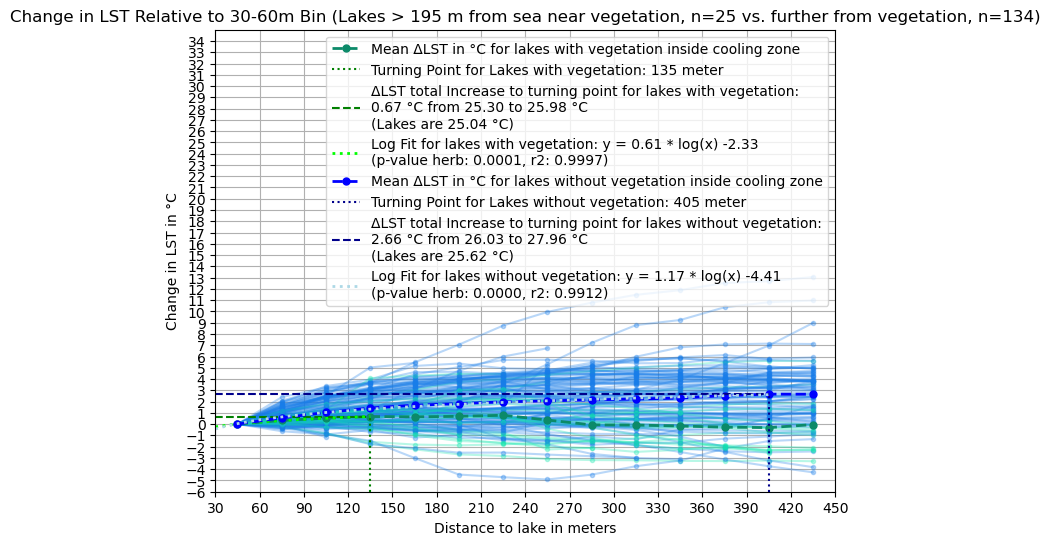

In [134]:
### Analysis 9A: Cooling effect from lakes close to vegetation (herbs + forest) vs. lakes not close to urban atlas vegetation (herbs+forest) - long distance
#  only calculates for lakes > 195 meters from the sea 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lake ids with herb
lakes_filtered_cool = lakes[lakes['cool_trend'].isin(['positive', 'negative'])] #159
lakes_herb_statistics_ids = np.sort(np.unique(lakes_filtered_cool['id']))

lakes_filtered_herb = lakes_filtered_cool[lakes_filtered_cool['vegOverlap'] >= 1] #25
lakes_with_herb_ids = np.sort(np.unique(lakes_filtered_herb['id']))

lakes_without_herb_ids = np.setdiff1d(lakes_herb_statistics_ids, lakes_with_herb_ids)
lakes_without_herb = lakes_filtered_cool[lakes_filtered_cool['id'].isin(lakes_without_herb_ids)] #134

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst_herb = []
all_delta_lst_not_herb = []

# Storage for zero LST across all lakes
all_lst_at_0_herb = []
all_lst_at_0_not_herb = []

# Storage for 30-60 LST across all lakes
all_lst_at_30_60_herb = []
all_lst_at_30_60_not_herb = []

# Iterate through each unique lake ID
for lake_id in lakes_herb_statistics_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 800) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_0_herb.append(lst_at_0)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_0_not_herb.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_30_60_herb.append(lst_at_30_60)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_30_60_not_herb.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    if lake_id in lakes_with_herb_ids:
        all_delta_lst_herb.append(delta_lst)
    elif lake_id in lakes_without_herb_ids:
        all_delta_lst_not_herb.append(delta_lst)
   
    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if lake_id in lakes_with_herb_ids: 
                line_color = '#14E7AE' # lakes with herb is colored green "green"
            else:
                line_color = '#187DE9' # lakes without herb is colored blue='#187DE9'

        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
mean_delta_lst_herb = np.nanmean(np.array(all_delta_lst_herb), axis=0)
mean_delta_lst_not_herb = np.nanmean(np.array(all_delta_lst_not_herb), axis=0)

# Compute LST across all lakes for dist=0
mean_lst_at_0_herb = np.nanmean(np.array(all_lst_at_0_herb), axis=0)
mean_lst_at_0_not_herb = np.nanmean(np.array(all_lst_at_0_not_herb), axis=0)

# Compute LST across all lakes for dist=30-60
mean_lst_at_30_60_herb = np.nanmean(np.array(all_lst_at_30_60_herb), axis=0)
mean_lst_at_30_60_not_herb = np.nanmean(np.array(all_lst_at_30_60_not_herb), axis=0)

# Compute the slope between successive bins
slopes_herb = np.diff(mean_delta_lst_herb) / np.diff(bin_labels)
slopes_not_herb = np.diff(mean_delta_lst_not_herb) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index_herb = np.argmax(slopes_herb < 0)
turning_point_index_not_herb = np.argmax(slopes_not_herb < 0)

if turning_point_index_herb > 0:
    turning_point_distance_herb = bin_labels[turning_point_index_herb]
else:
    turning_point_distance_herb = np.nan
if turning_point_index_not_herb > 0:
    turning_point_distance_not_herb = bin_labels[turning_point_index_not_herb]
else:
    turning_point_distance_not_herb = np.nan

# Get LST at the turning point which equals LST increase 
turning_point_lst_herb = mean_delta_lst_herb[turning_point_index_herb] if not np.isnan(turning_point_distance_herb) else np.nan
turning_point_lst_not_herb = mean_delta_lst_not_herb[turning_point_index_not_herb] if not np.isnan(turning_point_distance_not_herb) else np.nan

# Print results
print(f"LST at Lakes Herb (0m): {mean_lst_at_0_herb}")
print(f"LST at Lakes not Herb (0m): {mean_lst_at_0_not_herb}")
print(f"Turning Point Distance Herb (last increasing point before decrease): {turning_point_distance_herb} meters")
print(f"Turning Point Distance not Herb (last increasing point before decrease): {turning_point_distance_not_herb} meters")
print(f"LST at First Bin Herb (30-60m): {mean_lst_at_30_60_herb}")
print(f"LST at First Bin not Herb (30-60m): {mean_lst_at_30_60_not_herb}")
print(f"LST at Turning Point Herb: {mean_lst_at_30_60_herb+turning_point_lst_herb}")
print(f"LST at Turning Point not Herb: {mean_lst_at_30_60_not_herb+turning_point_lst_not_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point Herb: {turning_point_lst_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point not Herb: {turning_point_lst_not_herb}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 35
plt.ylim(y_start, y_end)

# Plots for lakes containing herb
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_herb, color='#0C8A69', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen
         label="Mean ΔLST in °C for lakes with vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_herb, ymin=y_start, ymax=turning_point_lst_herb, color='green', linestyle='dotted', 
            label=f"Turning Point for Lakes with vegetation: {turning_point_distance_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_herb, 30, turning_point_distance_herb, color='green', linestyle='--', 
           label=f"ΔLST total Increase to turning point for lakes with vegetation:\n{turning_point_lst_herb:.2f} °C from {(mean_lst_at_30_60_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_herb):.2f} °C\n(Lakes are {mean_lst_at_0_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_herb):
    valid_indices_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_herb)
    x_fit_herb = np.array(bin_labels)[valid_indices_herb]
    y_fit_herb = np.array(mean_delta_lst_herb)[valid_indices_herb]

    # Remove NaN values
    valid_mask_herb = ~np.isnan(y_fit_herb)
    x_fit_herb = x_fit_herb[valid_mask_herb]
    y_fit_herb = y_fit_herb[valid_mask_herb]

    if len(x_fit_herb) > 1:
        x_log_herb = np.log(x_fit_herb)
        x_log_with_const_herb = sm.add_constant(x_log_herb)
        model_herb = sm.OLS(y_fit_herb, x_log_with_const_herb)
        results_herb = model_herb.fit()

        a_herb = results_herb.params[1]
        b_herb = results_herb.params[0]
        p_value_herb = results_herb.pvalues[1]
        r2_value_herb = results_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_herb = np.linspace(30, turning_point_distance_herb, 100)
        y_fit_line_herb = a_herb * np.log(x_fit_line_herb) + b_herb
        plt.plot(x_fit_line_herb, y_fit_line_herb, color='lime', linestyle='dotted', linewidth=2, 
                 label=f"Log Fit for lakes with vegetation: y = {a_herb:.2f} * log(x) {b_herb:.2f}\n(p-value herb: {p_value_herb:.4f}, r2: {r2_value_herb:.4f})")

        print(f"P-value for logarithmic lakes with vegetation fit: {p_value_herb:.4f}")
        if p_value_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Plots for lakes without herb:
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen
         label="Mean ΔLST in °C for lakes without vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_not_herb, ymin=y_start, ymax=turning_point_lst_not_herb, color='darkblue', linestyle='dotted', 
            label=f"Turning Point for Lakes without vegetation: {turning_point_distance_not_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_not_herb, 30, turning_point_distance_not_herb, color='darkblue', linestyle='--', 
           label=f"ΔLST total Increase to turning point for lakes without vegetation:\n{turning_point_lst_not_herb:.2f} °C from {(mean_lst_at_30_60_not_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_not_herb):
    valid_indices_not_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_not_herb)
    x_fit_not_herb = np.array(bin_labels)[valid_indices_not_herb]
    y_fit_not_herb = np.array(mean_delta_lst_not_herb)[valid_indices_not_herb]

    # Remove NaN values
    valid_mask_not_herb = ~np.isnan(y_fit_not_herb)
    x_fit_not_herb = x_fit_not_herb[valid_mask_not_herb]
    y_fit_not_herb = y_fit_not_herb[valid_mask_not_herb]

    if len(x_fit_not_herb) > 1:
        x_log_not_herb = np.log(x_fit_not_herb)
        x_log_with_const_not_herb = sm.add_constant(x_log_not_herb)
        model_not_herb = sm.OLS(y_fit_not_herb, x_log_with_const_not_herb)
        results_not_herb = model_not_herb.fit()

        a_not_herb = results_not_herb.params[1]
        b_not_herb = results_not_herb.params[0]
        p_value_not_herb = results_not_herb.pvalues[1]
        r2_value_not_herb = results_not_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_not_herb = np.linspace(30, turning_point_distance_not_herb, 100)
        y_fit_line_not_herb = a_not_herb * np.log(x_fit_line_not_herb) + b_not_herb
        plt.plot(x_fit_line_not_herb, y_fit_line_not_herb, color='lightblue', linestyle='dotted', linewidth=2, 
                 label=f"Log Fit for lakes without vegetation: y = {a_not_herb:.2f} * log(x) {b_not_herb:.2f}\n(p-value herb: {p_value_not_herb:.4f}, r2: {r2_value_not_herb:.4f})")

        print(f"P-value for logarithmic lakes without vegetation fit: {p_value_not_herb:.4f}")
        if p_value_not_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Plot the mean ΔLST across all lakes
#plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, 
#         label=f"Mean ΔLST in °C for lakes without vegetation inside cooling zone\nNo turning point for lakes without vegetation:\nstarting from: {(mean_lst_at_30_60_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes > 195 m from sea near vegetation, n={len(lakes_with_herb_ids)} vs. further from vegetation, n={134})") #len(lakes_without_herb_ids)=151 but 3 are outOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='upper right')
plt.savefig("Fig9_lakesWithVegetationVSwithout.png", dpi=300, bbox_inches="tight")
plt.show()


In [132]:
# STATISTICS FOR LAKES WITH HERB VS LAKES WITHOUT HERB 
# Convert lists to numpy arrays
lst30_60_herb = np.array(all_lst_at_30_60_herb)
lst30_60_not_herb = np.array(all_lst_at_30_60_not_herb)

# Remove NaN values
lst30_60_herb = lst30_60_herb[~np.isnan(lst30_60_herb)]
lst30_60_not_herb = lst30_60_not_herb[~np.isnan(lst30_60_not_herb)]

u_stat, p_val_nonparam = mannwhitneyu(lst30_60_herb, lst30_60_not_herb, alternative='two-sided')
print("Mann-Whitney U statistic:", u_stat, "p-value:", p_val_nonparam)
#the Mann–Whitney test provides strong evidence that the two groups of lakes
#(with herbs versus without herbs) are statistically different in the metric you measured

#Mann–Whitney U test (U = 367, p ≈ 0.00275):
#This nonparametric test does not assume normality and shows a statistically significant difference between the two groups. 
#The low p-value indicates that the distributions (often interpreted as medians) of the two groups differ significantly.

#In the Mann–Whitney U test, the U statistic is calculated based on the ranks of all the values from both groups combined. 
#Essentially, it represents the number of times an observation in one group precedes an observation in the other group when 
#all observations are ordered from lowest to highest.

#So, when you see U = 367, it means that—after ranking the data—the test found that there were 367 “wins” for one group over the other. 
#While the number itself (367) isn't directly interpretable in isolation, it is used along with the sample sizes to determine the probability 
#(p-value) of obtaining such a result if the two groups were actually similar. In your case, the corresponding p-value (≈ 0.00275) 
#indicates that the observed difference in rankings between the two groups is highly unlikely to have occurred by chance.

Mann-Whitney U statistic: 1091.0 p-value: 0.007376682384126005
